#Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from collections import deque
import time
import copy
from tensorflow.keras import layers, regularizers
from copy import deepcopy

#Define Class Rectangle

In [ ]:
class Rectangle:
    def __init__(self, width, height, id_num=None):
        self.width = width
        self.height = height
        self.id = id_num
        self.x = 0
        self.y = 0
        self.rotated = False

    def get_area(self):
        return self.width * self.height

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated
        return self

    def can_fit(self, width, height):
        return (self.width <= width and self.height <= height) or (self.height <= width and self.width <= height)

    def __str__(self):
        return f"Rectangle(id={self.id}, width={self.width}, height={self.height}, position=({self.x}, {self.y}), rotated={self.rotated})"

#Define Cutting Stock Environment

In [ ]:
class CuttingStockEnvironment:
    def __init__(self, stock_width, stock_height, rectangles, max_sheets=5, kerf_width=3):
        self.stock_width = stock_width
        self.stock_height = stock_height
        self.original_rectangles = rectangles
        self.rectangles = []
        self.max_sheets = max_sheets
        self.kerf_width = kerf_width

        self.sheets = []
        self.current_sheet_idx = 0
        self.total_area_used = 0
        self.total_sheet_area = 0
        self.total_kerf_area = 0
        self.kerf_calculations = []

        self.grid_size = 10
        self.width_grid = self.stock_width // self.grid_size
        self.height_grid = self.stock_height // self.grid_size

        self.valid_positions = []

    def reset(self):
        self.rectangles = [Rectangle(r.width, r.height, r.id) for r in self.original_rectangles]
        self.rectangles = sorted(self.rectangles, key=lambda r: r.get_area(), reverse=True)

        self.sheets = []
        self.current_sheet_idx = 0
        self.total_area_used = 0
        self.total_sheet_area = 0
        self.total_kerf_area = 0
        self.kerf_calculations = []

        self._initialize_new_sheet()

        return self._get_state()

    def _initialize_new_sheet(self):
        new_sheet = np.zeros((self.stock_height, self.stock_width), dtype=np.int32)
        self.sheets.append(new_sheet)
        self.current_sheet_idx = len(self.sheets) - 1
        self.total_sheet_area += self.stock_width * self.stock_height

        self.valid_positions = [(0, 0)]

    def _calculate_kerf_loss(self, rect_x, rect_y, rect_width, rect_height):
        """Menghitung area yang hilang karena kerf (ketebalan pisau)"""
        current_sheet = self.sheets[self.current_sheet_idx]

        cuts_needed = []
        kerf_area = 0

        top_cut_needed = False
        bottom_cut_needed = False

        if rect_y + rect_height < self.stock_height:
            if np.any(current_sheet[rect_y + rect_height:, rect_x:rect_x + rect_width] > 0):
                top_cut_needed = True

        if rect_y > 0:
            if np.any(current_sheet[:rect_y, rect_x:rect_x + rect_width] > 0):
                bottom_cut_needed = True

        left_cut_needed = False
        right_cut_needed = False

        if rect_x > 0:
            if np.any(current_sheet[rect_y:rect_y + rect_height, :rect_x] > 0):
                left_cut_needed = True

        if rect_x + rect_width < self.stock_width:
            if np.any(current_sheet[rect_y:rect_y + rect_height, rect_x + rect_width:] > 0):
                right_cut_needed = True

        if top_cut_needed or bottom_cut_needed:
            horizontal_kerf = rect_width * self.kerf_width
            kerf_area += horizontal_kerf
            cuts_needed.append(f"Horizontal cut: {rect_width}mm x {self.kerf_width}mm = {horizontal_kerf}mm²")

        if left_cut_needed or right_cut_needed:
            vertical_kerf = rect_height * self.kerf_width
            kerf_area += vertical_kerf
            cuts_needed.append(f"Vertical cut: {rect_height}mm x {self.kerf_width}mm = {vertical_kerf}mm²")

        if len([r for r in current_sheet.flatten() if r > 0]) == 0:
            min_kerf = (rect_width + rect_height) * self.kerf_width
            if kerf_area < min_kerf:
                kerf_area = min_kerf
                cuts_needed = [
                    f"Initial horizontal cut: {rect_width}mm x {self.kerf_width}mm = {rect_width * self.kerf_width}mm²",
                    f"Initial vertical cut: {rect_height}mm x {self.kerf_width}mm = {rect_height * self.kerf_width}mm²"
                ]

        return kerf_area, cuts_needed

    def _update_valid_positions(self, rect_x, rect_y, rect_width, rect_height):
        if (rect_x, rect_y) in self.valid_positions:
            self.valid_positions.remove((rect_x, rect_y))

        right_pos = (rect_x + rect_width + self.kerf_width, rect_y)
        top_pos = (rect_x, rect_y + rect_height + self.kerf_width)

        if right_pos not in self.valid_positions and right_pos[0] < self.stock_width:
            self.valid_positions.append(right_pos)

        if top_pos not in self.valid_positions and top_pos[1] < self.stock_height:
            self.valid_positions.append(top_pos)

    def _get_state(self):
        current_sheet = self.sheets[self.current_sheet_idx]
        grid_layout = np.zeros((self.height_grid, self.width_grid), dtype=np.float32)

        for h in range(self.height_grid):
            for w in range(self.width_grid):
                h_start = h * self.grid_size
                w_start = w * self.grid_size
                grid_layout[h, w] = np.any(current_sheet[h_start:h_start+self.grid_size,
                                                      w_start:w_start+self.grid_size] > 0)

        flattened_grid = grid_layout.flatten()

        if len(self.rectangles) > 0:
            next_rect = self.rectangles[0]
            next_rect_info = np.array([
                next_rect.width / self.stock_width,
                next_rect.height / self.stock_height,
                self.kerf_width / self.stock_width
            ], dtype=np.float32)
        else:
            next_rect_info = np.zeros(3, dtype=np.float32)

        valid_pos_map = np.zeros((self.height_grid, self.width_grid), dtype=np.float32)
        for x, y in self.valid_positions:
            grid_x, grid_y = x // self.grid_size, y // self.grid_size
            if 0 <= grid_x < self.width_grid and 0 <= grid_y < self.height_grid:
                valid_pos_map[grid_y, grid_x] = 1.0

        state = np.concatenate([flattened_grid, valid_pos_map.flatten(), next_rect_info])
        return state

    def can_place_rectangle(self, x, y, width, height):
        if x + width > self.stock_width or y + height > self.stock_height:
            return False

        current_sheet = self.sheets[self.current_sheet_idx]
        area_to_check = current_sheet[y:y+height, x:x+width]
        return not np.any(area_to_check > 0)

    def step(self, action):
        if len(self.rectangles) == 0:
            return self._get_state(), 0, True, {"message": "No more rectangles"}

        pos_idx, rotate = action

        if not self.valid_positions:
            if self.current_sheet_idx < self.max_sheets - 1:
                self._initialize_new_sheet()
                return self._get_state(), -0.5, False, {"message": "New sheet initialized"}
            else:
                return self._get_state(), -1, True, {"message": "No valid positions left and max sheets reached"}

        if pos_idx >= len(self.valid_positions):
            return self._get_state(), -1, False, {"message": "Invalid position index"}

        x, y = self.valid_positions[pos_idx]
        rect = self.rectangles[0]

        if rotate == 1:
            rect.rotate()

        if not self.can_place_rectangle(x, y, rect.width, rect.height):
            if rotate == 1:
                rect.rotate()
            return self._get_state(), -0.5, False, {"message": "Invalid placement"}

        kerf_area, cuts_needed = self._calculate_kerf_loss(x, y, rect.width, rect.height)

        kerf_detail = {
            'piece_id': rect.id,
            'position': (x, y),
            'size': (rect.width, rect.height),
            'kerf_area': kerf_area,
            'cuts': cuts_needed,
            'sheet': self.current_sheet_idx + 1
        }
        self.kerf_calculations.append(kerf_detail)

        rect.x = x
        rect.y = y
        current_sheet = self.sheets[self.current_sheet_idx]
        current_sheet[y:y+rect.height, x:x+rect.width] = rect.id
        self.total_area_used += rect.get_area()
        self.total_kerf_area += kerf_area

        self._update_valid_positions(x, y, rect.width, rect.height)

        self.rectangles.pop(0)
        done = len(self.rectangles) == 0

        if not done and not any(self.can_place_rectangle(x, y, self.rectangles[0].width, self.rectangles[0].height) or
                              self.can_place_rectangle(x, y, self.rectangles[0].height, self.rectangles[0].width)
                              for x, y in self.valid_positions):
            if self.current_sheet_idx < self.max_sheets - 1:
                self._initialize_new_sheet()

        touching_edges_bonus = self._calculate_touching_edges(rect.x, rect.y, rect.width, rect.height)

        kerf_penalty = kerf_area / (self.stock_width * self.stock_height) * 0.5

        current_utilization = self.total_area_used / (self.total_sheet_area - self.total_kerf_area + 1e-6)
        reward = current_utilization + touching_edges_bonus * 0.1 - kerf_penalty

        if done:
            final_utilization = self.total_area_used / (self.total_sheet_area - self.total_kerf_area + 1e-6)
            reward += final_utilization * 2

        return self._get_state(), reward, done, {
            "utilization": current_utilization,
            "touching_edges": touching_edges_bonus,
            "kerf_area": kerf_area,
            "total_kerf": self.total_kerf_area
        }

    def _calculate_touching_edges(self, x, y, width, height):
        """Hitung jumlah sisi yang bersentuhan dengan potongan lain atau batas sheet"""
        current_sheet = self.sheets[self.current_sheet_idx]
        touching_count = 0

        # Cek kiri
        if x == 0:
            touching_count += height
        else:
            left_edge = current_sheet[y:y+height, max(0, x-self.kerf_width):x]
            touching_count += np.sum(left_edge > 0)

        # Cek kanan
        if x + width >= self.stock_width - self.kerf_width:
            touching_count += height
        else:
            right_edge = current_sheet[y:y+height, x+width:min(self.stock_width, x+width+self.kerf_width)]
            touching_count += np.sum(right_edge > 0)

        # Cek bawah
        if y == 0:
            touching_count += width
        else:
            bottom_edge = current_sheet[max(0, y-self.kerf_width):y, x:x+width]
            touching_count += np.sum(bottom_edge > 0)

        # Cek atas
        if y + height >= self.stock_height - self.kerf_width:
            touching_count += width
        else:
            top_edge = current_sheet[y+height:min(self.stock_height, y+height+self.kerf_width), x:x+width]
            touching_count += np.sum(top_edge > 0)

        perimeter = 2 * (width + height)
        return touching_count / perimeter

    def render(self):
      fig, axs = plt.subplots(2, len(self.sheets), figsize=(5 * len(self.sheets), 10))

      if len(self.sheets) == 1:
          axs = axs.reshape(2, 1)

      for i, sheet in enumerate(self.sheets):
          ax = axs[0, i]

          ax.set_xlim(0, self.stock_width)
          ax.set_ylim(0, self.stock_height)
          ax.set_aspect('equal')

          # Gambar sheet
          sheet_rect = patches.Rectangle((0, 0), self.stock_width, self.stock_height,
                                        linewidth=2, edgecolor='black', facecolor='lightgray', alpha=0.3)
          ax.add_patch(sheet_rect)

          # Gambar potongan
          color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
          unique_ids = np.unique(sheet)
          unique_ids = unique_ids[unique_ids > 0]

          for id_num in unique_ids:
              mask = sheet == id_num
              y_indices, x_indices = np.where(mask)
              if y_indices.size > 0 and x_indices.size > 0:
                  y_min, x_min = np.min(y_indices), np.min(x_indices)
                  height = np.max(y_indices) - y_min + 1
                  width = np.max(x_indices) - x_min + 1

                  color_idx = (id_num - 1) % len(color_cycle)
                  rect_patch = patches.Rectangle((x_min, y_min), width, height,
                                                linewidth=1, edgecolor='black',
                                                facecolor=color_cycle[color_idx], alpha=0.7)
                  ax.add_patch(rect_patch)

                  # Garis kerf horizontal (atas)
                  if y_min + height < self.stock_height:
                      kerf_rect = patches.Rectangle((x_min, y_min + height), width, self.kerf_width,
                                                  linewidth=0, facecolor='red', alpha=0.5)
                      ax.add_patch(kerf_rect)

                  # Garis kerf vertikal (kanan)
                  if x_min + width < self.stock_width:
                      kerf_rect = patches.Rectangle((x_min + width, y_min), self.kerf_width, height,
                                                  linewidth=0, facecolor='red', alpha=0.5)
                      ax.add_patch(kerf_rect)

                  ax.text(x_min + width/2, y_min + height/2, f"ID: {id_num}\n{width}x{height}",
                        ha='center', va='center', fontsize=8)

          ax.set_title(f'Sheet {i+1} - Layout dengan Kerf')
          ax.grid(True, alpha=0.3)

          ax2 = axs[1, i]

          ax2.axis('off')

          sheet_kerfs = [k for k in self.kerf_calculations if k['sheet'] == i + 1]

          info_text = f"Sheet {i+1} - Kerf Analysis\n"
          info_text += f"Kerf Width: {self.kerf_width}mm\n\n"

          total_kerf_this_sheet = sum(k['kerf_area'] for k in sheet_kerfs)
          info_text += f"Total Kerf Area: {total_kerf_this_sheet:.0f}mm²\n\n"

          for j, kerf in enumerate(sheet_kerfs):
              if j < 8:
                  info_text += f"Piece {kerf['piece_id']}: {kerf['kerf_area']:.0f}mm² kerf\n"
                  for cut in kerf['cuts']:
                      info_text += f"  • {cut}\n"
                  info_text += "\n"
              elif j == 8:
                  info_text += f"... and {len(sheet_kerfs) - 8} more pieces\n"
                  break

          ax2.text(0.05, 0.95, info_text, transform=ax2.transAxes, fontsize=8,
                  verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

      effective_utilization = self.total_area_used / (self.total_sheet_area - self.total_kerf_area + 1e-6)
      raw_utilization = self.total_area_used / self.total_sheet_area
      kerf_loss_percentage = 100 * self.total_kerf_area / self.total_sheet_area

      plt.suptitle(f'Cutting Stock Layout with Kerf Consideration\n'
                  f'Kerf Width: {self.kerf_width}mm | Raw Utilization: {raw_utilization:.3f} | '
                  f'Effective Utilization: {effective_utilization:.3f}\n'
                  f'Kerf Loss: {kerf_loss_percentage:.2f}% ({self.total_kerf_area:.0f}mm²)',
                  fontsize=12)

      plt.tight_layout()
      plt.subplots_adjust(top=0.85)
      plt.show()

    def print_kerf_summary(self):
        """Mencetak ringkasan perhitungan kerf"""
        print(f"\n{'='*60}")
        print(f"KERF CALCULATION SUMMARY")
        print(f"{'='*60}")
        print(f"Kerf Width (Blade Thickness): {self.kerf_width}mm")
        print(f"Total Material Used: {self.total_area_used:,.0f}mm²")
        print(f"Total Kerf Loss: {self.total_kerf_area:,.0f}mm²")
        print(f"Total Sheet Area: {self.total_sheet_area:,.0f}mm²")

        kerf_percentage = 100 * self.total_kerf_area / self.total_sheet_area
        raw_utilization = self.total_area_used / self.total_sheet_area
        effective_utilization = self.total_area_used / (self.total_sheet_area - self.total_kerf_area)

        print(f"\nUTILIZATION ANALYSIS:")
        print(f"Raw Utilization (ignoring kerf): {raw_utilization:.3f} ({100*raw_utilization:.1f}%)")
        print(f"Effective Utilization (considering kerf): {effective_utilization:.3f} ({100*effective_utilization:.1f}%)")
        print(f"Kerf Loss Percentage: {kerf_percentage:.2f}%")

        print(f"\nDETAILED KERF BREAKDOWN BY SHEET:")
        for sheet_num in range(1, len(self.sheets) + 1):
            sheet_kerfs = [k for k in self.kerf_calculations if k['sheet'] == sheet_num]
            sheet_kerf_total = sum(k['kerf_area'] for k in sheet_kerfs)
            print(f"  Sheet {sheet_num}: {sheet_kerf_total:,.0f}mm² kerf loss ({len(sheet_kerfs)} pieces)")

In [ ]:
def get_valid_actions(env):
    """Mengembalikan daftar aksi valid berdasarkan state saat ini"""
    valid_actions = []

    if len(env.rectangles) == 0 or not env.valid_positions:
        return valid_actions

    next_rect = env.rectangles[0]

    for pos_idx, (x, y) in enumerate(env.valid_positions):
        # Tanpa rotasi
        if env.can_place_rectangle(x, y, next_rect.width, next_rect.height):
            valid_actions.append((pos_idx, 0))

        # Dengan rotasi
        if env.can_place_rectangle(x, y, next_rect.height, next_rect.width):
            valid_actions.append((pos_idx, 1))

    return valid_actions

def action_to_tuple(action, max_positions):
    """Convert action index to (pos_idx, rotation)"""
    rotation = action % 2
    pos_idx = action // 2
    return (pos_idx % max_positions, rotation)

#Define Visualize Kerf

In [ ]:
def compare_kerf_widths(stock_width, stock_height, rectangles, kerf_widths=[1, 2, 3, 4, 5]):
    """Membandingkan efek berbagai ketebalan pisau terhadap utilisasi"""
    results = []

    print("Comparing different kerf widths...")
    for kerf in kerf_widths:
        print(f"\nTesting kerf width: {kerf}mm")
        env = bottom_left_packing(stock_width, stock_height, rectangles, kerf_width=kerf)

        raw_utilization = env.total_area_used / env.total_sheet_area
        effective_utilization = env.total_area_used / (env.total_sheet_area - env.total_kerf_area + 1e-6)
        kerf_loss_percentage = 100 * env.total_kerf_area / env.total_sheet_area

        results.append({
            'kerf_width': kerf,
            'raw_utilization': raw_utilization,
            'effective_utilization': effective_utilization,
            'kerf_loss_percentage': kerf_loss_percentage,
            'total_kerf_area': env.total_kerf_area,
            'sheets_used': len(env.sheets)
        })

        print(f"  Raw utilization: {raw_utilization:.3f}")
        print(f"  Effective utilization: {effective_utilization:.3f}")
        print(f"  Kerf loss: {kerf_loss_percentage:.2f}%")

    return results

def plot_kerf_comparison(kerf_results):
    """Plot perbandingan hasil untuk berbagai ketebalan pisau"""
    kerf_widths = [r['kerf_width'] for r in kerf_results]
    raw_utils = [r['raw_utilization'] for r in kerf_results]
    eff_utils = [r['effective_utilization'] for r in kerf_results]
    kerf_losses = [r['kerf_loss_percentage'] for r in kerf_results]
    sheets_used = [r['sheets_used'] for r in kerf_results]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.plot(kerf_widths, raw_utils, 'b-o', label='Raw Utilization', linewidth=2)
    ax1.plot(kerf_widths, eff_utils, 'r-s', label='Effective Utilization', linewidth=2)
    ax1.set_xlabel('Kerf Width (mm)')
    ax1.set_ylabel('Utilization')
    ax1.set_title('Utilization vs Kerf Width')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(kerf_widths, kerf_losses, 'g-^', linewidth=2, color='orange')
    ax2.set_xlabel('Kerf Width (mm)')
    ax2.set_ylabel('Kerf Loss (%)')
    ax2.set_title('Material Loss vs Kerf Width')
    ax2.grid(True, alpha=0.3)

    ax3.bar(kerf_widths, sheets_used, color='purple', alpha=0.7)
    ax3.set_xlabel('Kerf Width (mm)')
    ax3.set_ylabel('Number of Sheets')
    ax3.set_title('Sheets Used vs Kerf Width')
    ax3.grid(True, alpha=0.3)

    kerf_areas = [r['total_kerf_area'] for r in kerf_results]
    ax4.plot(kerf_widths, kerf_areas, 'r-d', linewidth=2, color='red')
    ax4.set_xlabel('Kerf Width (mm)')
    ax4.set_ylabel('Total Kerf Area (mm²)')
    ax4.set_title('Total Kerf Area vs Kerf Width')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#Build Model

##Heuristik Bottom-Left

In [ ]:
def bottom_left_packing(stock_width, stock_height, rectangles, kerf_width=3):
    env = CuttingStockEnvironment(stock_width, stock_height, rectangles, kerf_width=kerf_width)
    env.reset()

    while len(env.rectangles) > 0:
        rect = env.rectangles[0]
        placed = False

        for pos_idx, (x, y) in enumerate(env.valid_positions):
            # Coba tanpa rotasi
            if env.can_place_rectangle(x, y, rect.width, rect.height):
                action = (pos_idx, 0)
                env.step(action)
                placed = True
                break

            # Coba dengan rotasi
            if env.can_place_rectangle(x, y, rect.height, rect.width):
                action = (pos_idx, 1)
                env.step(action)
                placed = True
                break

        if not placed:
            if env.current_sheet_idx < env.max_sheets - 1:
                env._initialize_new_sheet()
            else:
                print(f"Tidak dapat menempatkan semua potongan. {len(env.rectangles)} potongan tersisa.")
                break

    return env

##Deep Q-Network Agent

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = keras.Sequential([
            keras.Input(shape=(self.state_size,)),
            layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        if self.model is not None and self.target_model is not None:
            self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, valid_actions_indices=None):
        if valid_actions_indices is None:
            valid_actions_indices = list(range(self.action_size))

        if not valid_actions_indices:
            print("Peringatan: DQNAgent.act dipanggil dengan tidak ada_aksi_valid. Mengembalikan aksi acak dari semua kemungkinan.")
            return np.random.randint(0, self.action_size) if self.action_size > 0 else 0

        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions_indices)

        if self.model is None:
            print("Error: Model DQN belum diinisialisasi atau dimuat.")
            return random.choice(valid_actions_indices)


        act_values = self.model.predict(np.array([state]), verbose=0)[0]

        best_action = -1
        max_q_value = -np.inf

        for action_idx in valid_actions_indices:
            if 0 <= action_idx < len(act_values):
                if act_values[action_idx] > max_q_value:
                    max_q_value = act_values[action_idx]
                    best_action = action_idx

        if best_action != -1:
            return best_action
        else:
            return random.choice(valid_actions_indices)

    def replay(self, batch_size):
        if len(self.memory) < batch_size or self.model is None or self.target_model is None:
            return

        minibatch = random.sample(self.memory, batch_size)

        states = np.array([transition[0] for transition in minibatch])
        next_states = np.array([transition[3] for transition in minibatch])

        current_q_values_batch = self.model.predict(states, verbose=0, batch_size=batch_size)
        next_q_values_target_batch = self.target_model.predict(next_states, verbose=0, batch_size=batch_size)

        updated_q_values = np.copy(current_q_values_batch)

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.amax(next_q_values_target_batch[i])

            updated_q_values[i, action] = target

        self.model.fit(states, updated_q_values, epochs=1, verbose=0, batch_size=batch_size)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name_or_path):
        """Memuat seluruh model dari path yang diberikan."""
        try:
            print(f"Mencoba memuat model lengkap DQN dari: {name_or_path}")
            self.model = keras.models.load_model(name_or_path)
            print(f"Model utama DQN berhasil dimuat dari {name_or_path}")

            print("Menginisialisasi dan menyinkronkan target model...")
            self.target_model = keras.models.clone_model(self.model)
            self.target_model.set_weights(self.model.get_weights())
            print("Target model berhasil disinkronkan.")

        except Exception as e:
            print(f"Gagal memuat model lengkap DQN dengan keras.models.load_model: {e}")
            print("Pastikan file model tidak korup dan kompatibel.")
            raise

    def save(self, name):
        if not name.endswith(".keras"):
             name += ".keras"
        self.model.save(name)

In [ ]:
def train_cutting_stock_rl(stock_width, stock_height, rectangles, episodes, kerf_width):
    env = CuttingStockEnvironment(stock_width, stock_height, rectangles, kerf_width=kerf_width)

    state_size = env.width_grid * env.height_grid * 2 + 3

    max_positions = env.stock_width * env.stock_height // (env.grid_size * env.grid_size)
    action_size = max_positions * 2

    agent = DQNAgent(state_size, action_size)
    batch_size = 32

    best_utilization = 0
    best_env = None

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while True:
            valid_actions_tuples = get_valid_actions(env)

            if not valid_actions_tuples:
                break

            valid_actions = []
            for pos_idx, rotation in valid_actions_tuples:
                action_idx = pos_idx * 2 + rotation
                valid_actions.append(action_idx)

            action_idx = agent.act(state, valid_actions)
            action = action_to_tuple(action_idx, max_positions)

            next_state, reward, done, info = env.step(action)
            agent.remember(state, action_idx, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

            if done or steps > 100:
                break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        if e % 10 == 0:
            agent.update_target_model()

        utilization = env.total_area_used / (env.total_sheet_area - env.total_kerf_area + 1e-6)
        if utilization > best_utilization:
            best_utilization = utilization
            best_env = copy.deepcopy(env)

        print(f"Episode: {e+1}/{episodes}, Steps: {steps}, Reward: {total_reward:.2f}, "
              f"Utilization: {utilization:.2f}, Kerf Loss: {env.total_kerf_area:.0f}mm², Epsilon: {agent.epsilon:.2f}")

    print(f"Training completed. Best utilization: {best_utilization:.2f}")
    return best_env, agent

##Policy Gradient

In [ ]:
class PolicyGradientAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)

        self.model = self._build_model()

        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    def _build_model(self):
        model = keras.Sequential([
            layers.Dense(64, input_dim=self.state_size, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(self.action_size, activation='softmax')
        ])
        return model

    def remember(self, state, action, reward):
        self.state_memory.append(state)
        self.action_memory.append(action)
        self.reward_memory.append(reward)

    def act(self, state, valid_actions_indices=None):
        state_reshaped = np.array([state])
        probabilities = self.model.predict(state_reshaped, verbose=0)[0]

        if valid_actions_indices is not None and len(valid_actions_indices) > 0:
            masked_probabilities = np.zeros_like(probabilities)
            for i in valid_actions_indices:
                if i < len(masked_probabilities):
                    masked_probabilities[i] = probabilities[i]

            if np.sum(masked_probabilities) > 0:
                masked_probabilities /= np.sum(masked_probabilities)
            else:
                if len(valid_actions_indices) > 0:
                    return np.random.choice(valid_actions_indices)
                else:
                    return np.random.choice(self.action_size)

            action = np.random.choice(self.action_size, p=masked_probabilities)
        else:
            if len(valid_actions_indices) == 0 and valid_actions_indices is not None:
                 print("Warning: PolicyGradientAgent.act called with empty valid_actions_indices. Choosing random action.")
                 return np.random.choice(self.action_size)
            action = np.random.choice(self.action_size, p=probabilities)
        return action


    def learn(self):
        if not self.state_memory:
            return 0

        G = np.zeros_like(self.reward_memory, dtype=np.float32)
        cumulative_reward = 0
        for t in reversed(range(len(self.reward_memory))):
            cumulative_reward = self.reward_memory[t] + self.gamma * cumulative_reward
            G[t] = cumulative_reward

        G_mean = np.mean(G)
        G_std = np.std(G) if np.std(G) > 0 else 1
        G_normalized = (G - G_mean) / G_std

        with tf.GradientTape() as tape:
            loss = 0
            for i in range(len(self.state_memory)):
                state = self.state_memory[i]
                action = self.action_memory[i]
                reward = G_normalized[i]

                state_reshaped = np.array([state])
                probabilities = self.model(state_reshaped)

                action_prob = probabilities[0, action]
                log_prob = tf.math.log(action_prob + 1e-7)
                loss += -log_prob * reward


        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        return loss.numpy() / len(G) if len(G) > 0 else 0

    def save(self, name):
        if not name.endswith(".keras"):
            name += ".keras"
        self.model.save(name)

    def load(self, name):
        try:
            if not name.endswith(".keras"):
                name += ".keras"
            print(f"Mencoba memuat model Policy Gradient dari: {name}")
            self.model = keras.models.load_model(name)
            print(f"Model Policy Gradient berhasil dimuat dari {name}")
        except Exception as e:
            print(f"Error memuat model Policy Gradient: {e}. Pastikan file model tidak korup dan kompatibel.")
            raise

In [ ]:
def train_policy_gradient_cutting_stock(stock_width, stock_height, rectangles, episodes=500, kerf_width=3):
    env = CuttingStockEnvironment(stock_width, stock_height, rectangles, kerf_width=kerf_width)
    state_size = env.width_grid * env.height_grid * 2 + 3
    max_positions_env = env.stock_width * env.stock_height // (env.grid_size * env.grid_size)
    action_size = max_positions_env * 2

    agent = PolicyGradientAgent(state_size, action_size)
    best_utilization = 0
    best_env = None

    episode_rewards = []

    for e in range(episodes):
        state = env.reset()
        episode_reward = 0
        steps = 0
        current_episode_states, current_episode_actions, current_episode_rewards = [], [], []

        while True:
            valid_actions_tuples = get_valid_actions(env)
            if not valid_actions_tuples:
                break

            valid_action_indices = []
            for pos_idx, rotation in valid_actions_tuples:
                action_idx = pos_idx * 2 + rotation
                if action_idx < action_size :
                    valid_action_indices.append(action_idx)

            if not valid_action_indices:
                break

            action_idx = agent.act(state, valid_action_indices)
            action_tuple_to_env = action_to_tuple(action_idx, max_positions_env)

            next_state, reward, done_env, info = env.step(action_tuple_to_env)

            agent.remember(state, action_idx, reward)

            state = next_state
            episode_reward += reward
            steps += 1

            if done_env or steps > 100:
                break

        agent.learn()

        utilization = env.total_area_used / (env.total_sheet_area - env.total_kerf_area + 1e-6) if (env.total_sheet_area - env.total_kerf_area) > 1e-6 else 0
        episode_rewards.append(episode_reward)

        if utilization > best_utilization:
            best_utilization = utilization
            best_env = copy.deepcopy(env)

        print(f"PG Episode: {e+1}/{episodes}, Steps: {steps}, Reward: {episode_reward:.2f}, "
              f"Utilization: {utilization:.2f}, Kerf Loss: {env.total_kerf_area:.0f}mm²")

    print(f"Policy Gradient Training completed. Best utilization: {best_utilization:.2f}")
    return best_env, agent

##Actor Critic

In [ ]:
class A2CAgent:
    def __init__(self, state_size, action_size, actor_lr=0.001, critic_lr=0.005, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        self.actor = self._build_actor()
        self.critic = self._build_critic()

        self.actor_optimizer = keras.optimizers.Adam(learning_rate=self.actor_lr)
        self.critic_optimizer = keras.optimizers.Adam(learning_rate=self.critic_lr)

    def _build_actor(self):
        model = keras.Sequential([
            layers.Dense(64, input_dim=self.state_size, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(self.action_size, activation='softmax')
        ])
        return model

    def _build_critic(self):
        model = keras.Sequential([
            layers.Dense(64, input_dim=self.state_size, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='linear')
        ])
        return model

    def act(self, state, valid_actions_indices=None):
        state_reshaped = np.array([state])
        probabilities = self.actor.predict(state_reshaped, verbose=0)[0]

        if valid_actions_indices is not None and len(valid_actions_indices) > 0:
            masked_probabilities = np.zeros_like(probabilities)
            for i in valid_actions_indices:
                if i < len(masked_probabilities):
                     masked_probabilities[i] = probabilities[i]

            if np.sum(masked_probabilities) > 0:
                masked_probabilities /= np.sum(masked_probabilities)
            else:
                if len(valid_actions_indices) > 0:
                    return np.random.choice(valid_actions_indices), 0
                else:
                    return np.random.choice(self.action_size), 0


            action = np.random.choice(self.action_size, p=masked_probabilities)
            entropy = 0
        else:
            if len(valid_actions_indices) == 0 and valid_actions_indices is not None:
                 print("Warning: A2CAgent.act called with empty valid_actions_indices. Choosing random action.")
                 return np.random.choice(self.action_size), 0
            action = np.random.choice(self.action_size, p=probabilities)
            entropy = 0

        return action, entropy

    def learn(self, state, action, reward, next_state, done):
        state_reshaped = np.array([state])
        next_state_reshaped = np.array([next_state])

        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            value = self.critic(state_reshaped, training=True)
            next_value = self.critic(next_state_reshaped, training=True)

            target = reward + self.gamma * next_value * (1 - int(done))
            advantage = target - value

            critic_loss = keras.losses.MSE(target, value)

            probabilities = self.actor(state_reshaped, training=True)
            action_prob = probabilities[0, action]
            log_prob = tf.math.log(action_prob + 1e-7)
            actor_loss = -log_prob * tf.stop_gradient(advantage)

        actor_gradients = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_gradients = critic_tape.gradient(critic_loss, self.critic.trainable_variables)

        self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))

        return actor_loss.numpy(), critic_loss.numpy()

    def save(self, name_prefix):
        self.actor.save(f"{name_prefix}_actor.keras")
        self.critic.save(f"{name_prefix}_critic.keras")

    def load(self, name_actor, name_critic):
        """Loads the models from the given paths."""
        try:
            if not name_actor.endswith(".keras"):
                name_actor += ".keras"
            if not name_critic.endswith(".keras"):
                name_critic += ".keras"

            print(f"Mencoba memuat model Actor dari: {name_actor}")
            self.actor = keras.models.load_model(name_actor)
            print(f"Model Actor berhasil dimuat dari {name_actor}")

            print(f"Mencoba memuat model Critic dari: {name_critic}")
            self.critic = keras.models.load_model(name_critic)
            print(f"Model Critic berhasil dimuat dari {name_critic}")

        except Exception as e:
            print(f"Error memuat model A2C: {e}. Pastikan file model tidak korup dan kompatibel.")
            raise

In [ ]:
def train_a2c_cutting_stock(stock_width, stock_height, rectangles, episodes=500, kerf_width=3):
    env = CuttingStockEnvironment(stock_width, stock_height, rectangles, kerf_width=kerf_width)
    state_size = env.width_grid * env.height_grid * 2 + 3
    max_positions_env = env.stock_width * env.stock_height // (env.grid_size * env.grid_size)
    action_size = max_positions_env * 2

    agent = A2CAgent(state_size, action_size)
    best_utilization = 0
    best_env = None

    episode_rewards = []

    for e in range(episodes):
        state = env.reset()
        episode_reward = 0
        steps = 0
        actor_losses_episode = []
        critic_losses_episode = []

        while True:
            valid_actions_tuples = get_valid_actions(env)
            if not valid_actions_tuples:
                break

            valid_action_indices = []
            for pos_idx, rotation in valid_actions_tuples:
                action_idx = pos_idx * 2 + rotation
                if action_idx < action_size :
                    valid_action_indices.append(action_idx)

            if not valid_action_indices:
                break

            action_idx, _ = agent.act(state, valid_action_indices)
            action_tuple_to_env = action_to_tuple(action_idx, max_positions_env)

            next_state, reward, done_env, info = env.step(action_tuple_to_env)
            actor_loss, critic_loss = agent.learn(state, action_idx, reward, next_state, done_env)

            actor_losses_episode.append(actor_loss)
            critic_losses_episode.append(critic_loss)

            state = next_state
            episode_reward += reward
            steps += 1

            if done_env or steps > 100:
                break

        utilization = env.total_area_used / (env.total_sheet_area - env.total_kerf_area + 1e-6) if (env.total_sheet_area - env.total_kerf_area) > 1e-6 else 0
        episode_rewards.append(episode_reward)

        if utilization > best_utilization:
            best_utilization = utilization
            best_env = copy.deepcopy(env)

        avg_actor_loss = np.mean(actor_losses_episode) if actor_losses_episode else 0
        avg_critic_loss = np.mean(critic_losses_episode) if critic_losses_episode else 0

        print(f"A2C Episode: {e+1}/{episodes}, Steps: {steps}, Reward: {episode_reward:.2f}, "
              f"Util: {utilization:.2f}, Kerf: {env.total_kerf_area:.0f}mm², "
              f"ActorL: {avg_actor_loss:.2f}, CriticL: {avg_critic_loss:.2f}")

    print(f"A2C Training completed. Best utilization: {best_utilization:.2f}")
    return best_env, agent

#Camparison All RL Model

In [ ]:
def compare_all_rl_methods(stock_width, stock_height, rectangles, episodes=100, kerf_width=3):
    print("=" * 80)
    print("COMPARING ALL REINFORCEMENT LEARNING METHODS")
    print("=" * 80)

    results = {}
    method_names = ['PolicyGradient', 'A2C', 'DQN']

    # Policy Gradient Training
    print("\nTraining Policy Gradient (REINFORCE)...")
    start_time = time.time()
    pg_env, pg_agent = train_policy_gradient_cutting_stock(stock_width, stock_height, copy.deepcopy(rectangles),
                                                          episodes=episodes, kerf_width=kerf_width)
    pg_time = time.time() - start_time
    pg_utilization = pg_env.total_area_used / (pg_env.total_sheet_area - pg_env.total_kerf_area + 1e-6) if (pg_env.total_sheet_area - pg_env.total_kerf_area) > 1e-6 else 0
    results['PolicyGradient'] = {
        'env': pg_env,
        'agent': pg_agent,
        'utilization': pg_utilization,
        'time': pg_time,
        'sheets': len(pg_env.sheets),
        'kerf_loss': pg_env.total_kerf_area
    }

    # A2C Training
    print("\nTraining A2C...")
    start_time = time.time()
    a2c_env, a2c_agent = train_a2c_cutting_stock(stock_width, stock_height, copy.deepcopy(rectangles),
                                                episodes=episodes, kerf_width=kerf_width)
    a2c_time = time.time() - start_time
    a2c_utilization = a2c_env.total_area_used / (a2c_env.total_sheet_area - a2c_env.total_kerf_area + 1e-6) if (a2c_env.total_sheet_area - a2c_env.total_kerf_area) > 1e-6 else 0
    results['A2C'] = {
        'env': a2c_env,
        'agent': a2c_agent,
        'utilization': a2c_utilization,
        'time': a2c_time,
        'sheets': len(a2c_env.sheets),
        'kerf_loss': a2c_env.total_kerf_area
    }

    # DQN Training
    print("\nTraining DQN...")
    start_time = time.time()
    dqn_env, dqn_agent = train_cutting_stock_rl(stock_width, stock_height, copy.deepcopy(rectangles),
                                               episodes=episodes, kerf_width=kerf_width)
    dqn_time = time.time() - start_time
    dqn_utilization = dqn_env.total_area_used / (dqn_env.total_sheet_area - dqn_env.total_kerf_area + 1e-6) if (dqn_env.total_sheet_area - dqn_env.total_kerf_area) > 1e-6 else 0
    results['DQN'] = {
        'env': dqn_env,
        'agent': dqn_agent,
        'utilization': dqn_utilization,
        'time': dqn_time,
        'sheets': len(dqn_env.sheets),
        'kerf_loss': dqn_env.total_kerf_area
    }

    methods = list(results.keys())
    utilizations = [results[method]['utilization'] for method in methods]
    times = [results[method]['time'] for method in methods]
    sheets_used = [results[method]['sheets'] for method in methods]
    kerf_losses = [results[method]['kerf_loss'] for method in methods]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    bar_colors = ['blue', 'green', 'red', 'purple', 'orange'][:len(methods)]


    bars1 = ax1.bar(methods, [u*100 for u in utilizations], color=bar_colors, alpha=0.7)
    ax1.set_ylabel('Effective Utilization (%)')
    ax1.set_title('Material Utilization Comparison')
    ax1.grid(True, alpha=0.3)
    for bar, util in zip(bars1, utilizations):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{util*100:.1f}%', ha='center', va='bottom', fontweight='bold')

    bars2 = ax2.bar(methods, times, color=bar_colors, alpha=0.7)
    ax2.set_ylabel('Training Time (seconds)')
    ax2.set_title('Training Time Comparison')
    ax2.grid(True, alpha=0.3)
    for bar, time_val in zip(bars2, times):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(times, default=1)*0.01,
                f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')


    bars3 = ax3.bar(methods, sheets_used, color=bar_colors, alpha=0.7)
    ax3.set_ylabel('Number of Sheets')
    ax3.set_title('Sheets Used Comparison')
    ax3.grid(True, alpha=0.3)
    ax3.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    for bar, sheets_val in zip(bars3, sheets_used):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{sheets_val}', ha='center', va='bottom', fontweight='bold')


    bars4 = ax4.bar(methods, kerf_losses, color=bar_colors, alpha=0.7)
    ax4.set_ylabel('Kerf Loss (mm²)')
    ax4.set_title('Material Waste Comparison')
    ax4.grid(True, alpha=0.3)
    for bar, kerf_val in zip(bars4, kerf_losses):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(kerf_losses, default=1)*0.01,
                f'{kerf_val:.0f}', ha='center', va='bottom', fontweight='bold')


    plt.suptitle(f'Reinforcement Learning Methods Comparison (Episodes: {episodes}, Kerf: {kerf_width}mm)',
                 fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print("\n" + "=" * 80)
    print("DETAILED COMPARISON RESULTS")
    print("=" * 80)
    print(f"{'Method':<15} {'Utilization':<12} {'Time (s)':<10} {'Sheets':<8} {'Kerf Loss':<12}")
    print("-" * 80)

    for method in methods:
        result = results[method]
        print(f"{method:<15} {result['utilization']*100:<11.1f}% {result['time']:<9.1f} "
              f"{result['sheets']:<8} {result['kerf_loss']:<11.0f}mm²")

    if utilizations:
        best_method_idx = np.argmax(utilizations)
        best_method = methods[best_method_idx]
        print(f"\nBest performing method (by utilization): {best_method} with {results[best_method]['utilization']*100:.1f}% utilization")
    else:
        print("\nNo results to determine the best performing method.")

    for method in methods:
        print(f"Attempting to save model for {method}...")
        try:
            if method == 'DQN' or method == 'PolicyGradient' or method == 'A2C':
                 if method in results and 'agent' in results[method] and results[method]['agent'] is not None:
                     save_path = f"cutting_stock_{method.lower()}_kerf"
                     results[method]['agent'].save(save_path)
                     print(f"Model for {method} successfully saved to {save_path}.")
                 else:
                     print(f"Error: Agent for {method} not found or is None in results.")
            else:
                 print(f"Warning: Method {method} not handled for saving.")
        except Exception as e:
            print(f"Error saving model for {method}: {e}")
        print("-" * 20)


    print("\nAll models saved successfully!")
    return results

COMPARING ALL REINFORCEMENT LEARNING METHODS

Training Policy Gradient (REINFORCE)...
PG Episode: 1/1, Steps: 25, Reward: 16.94, Utilization: 0.85, Kerf Loss: 41700mm²
Policy Gradient Training completed. Best utilization: 0.85

Training A2C...
A2C Episode: 1/1, Steps: 25, Reward: 13.09, Util: 0.42, Kerf: 39150mm², ActorL: -28.34, CriticL: 304.09
A2C Training completed. Best utilization: 0.42

Training DQN...
Episode: 1/1, Steps: 25, Reward: 12.60, Utilization: 0.42, Kerf Loss: 38250mm², Epsilon: 1.00
Training completed. Best utilization: 0.42


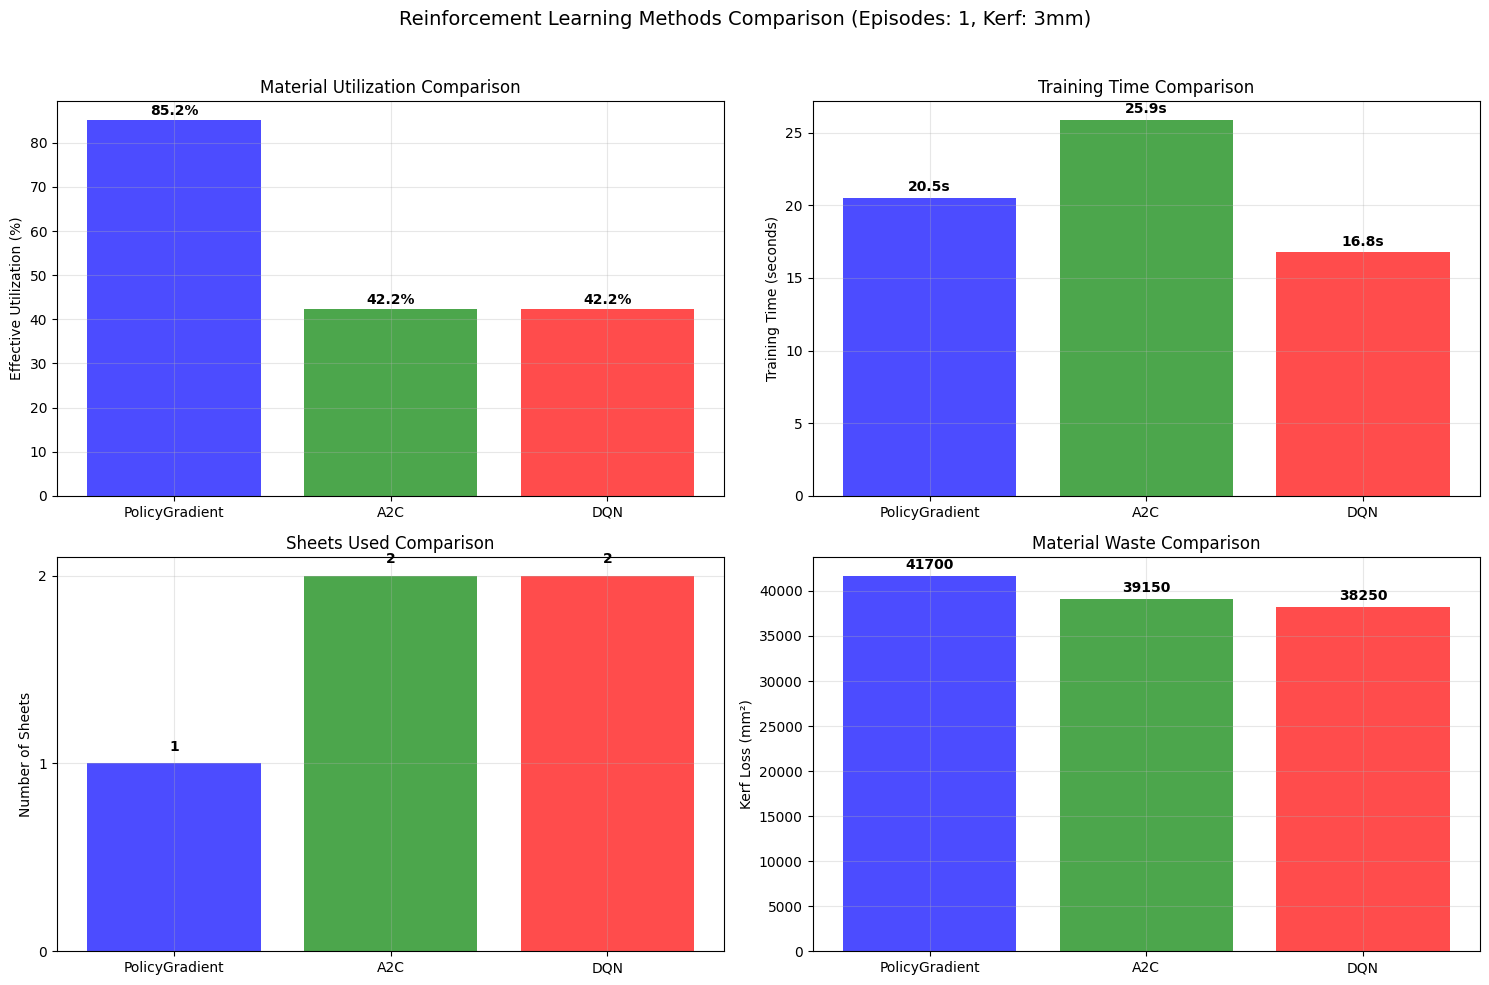


DETAILED COMPARISON RESULTS
Method          Utilization  Time (s)   Sheets   Kerf Loss   
--------------------------------------------------------------------------------
PolicyGradient  85.2       % 20.5      1        41700      mm²
A2C             42.2       % 25.9      2        39150      mm²
DQN             42.2       % 16.8      2        38250      mm²

Best performing method (by utilization): PolicyGradient with 85.2% utilization
Attempting to save model for PolicyGradient...
Model for PolicyGradient successfully saved to cutting_stock_policygradient_kerf.
--------------------
Attempting to save model for A2C...
Model for A2C successfully saved to cutting_stock_a2c_kerf.
--------------------
Attempting to save model for DQN...
Model for DQN successfully saved to cutting_stock_dqn_kerf.
--------------------

All models saved successfully!

Rendering result from PolicyGradient:


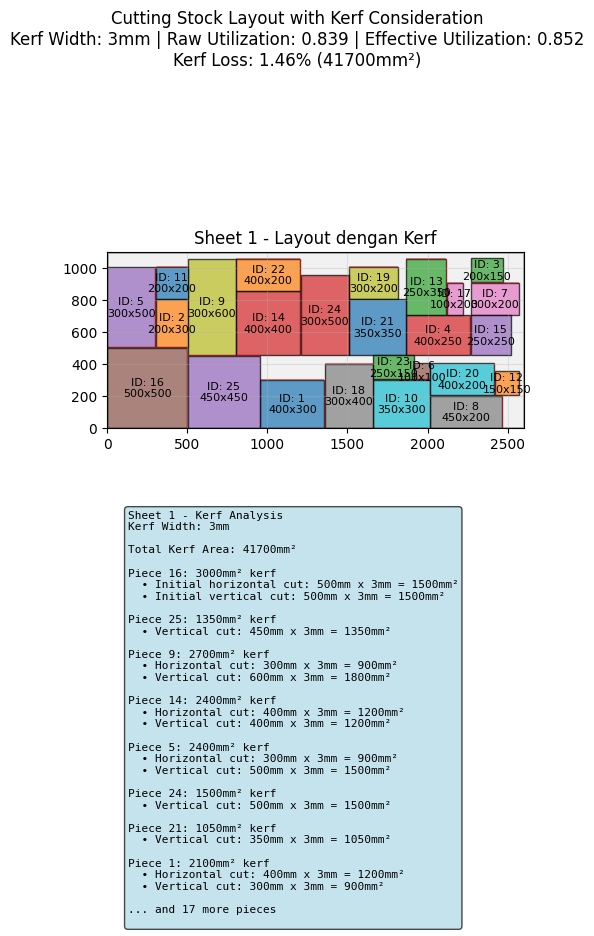


KERF CALCULATION SUMMARY
Kerf Width (Blade Thickness): 3mm
Total Material Used: 2,400,000mm²
Total Kerf Loss: 41,700mm²
Total Sheet Area: 2,860,000mm²

UTILIZATION ANALYSIS:
Raw Utilization (ignoring kerf): 0.839 (83.9%)
Effective Utilization (considering kerf): 0.852 (85.2%)
Kerf Loss Percentage: 1.46%

DETAILED KERF BREAKDOWN BY SHEET:
  Sheet 1: 41,700mm² kerf loss (25 pieces)

Rendering result from A2C:


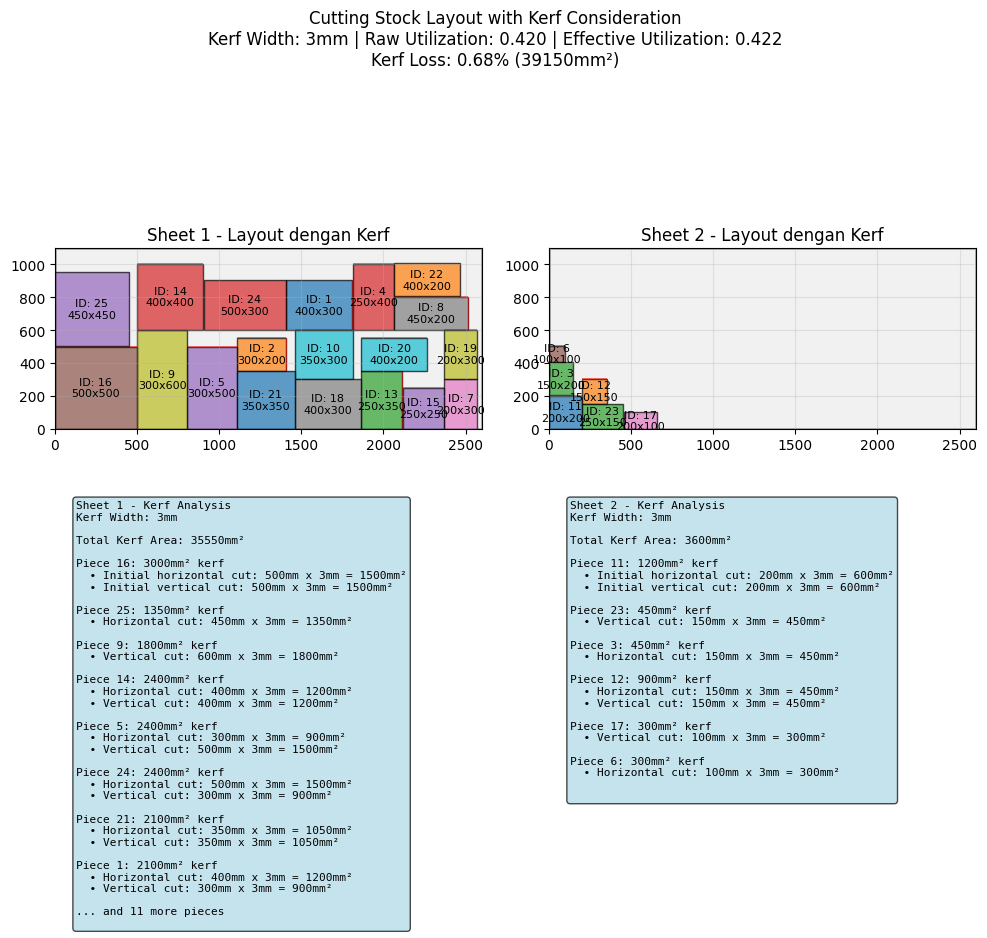


KERF CALCULATION SUMMARY
Kerf Width (Blade Thickness): 3mm
Total Material Used: 2,400,000mm²
Total Kerf Loss: 39,150mm²
Total Sheet Area: 5,720,000mm²

UTILIZATION ANALYSIS:
Raw Utilization (ignoring kerf): 0.420 (42.0%)
Effective Utilization (considering kerf): 0.422 (42.2%)
Kerf Loss Percentage: 0.68%

DETAILED KERF BREAKDOWN BY SHEET:
  Sheet 1: 35,550mm² kerf loss (19 pieces)
  Sheet 2: 3,600mm² kerf loss (6 pieces)

Rendering result from DQN:


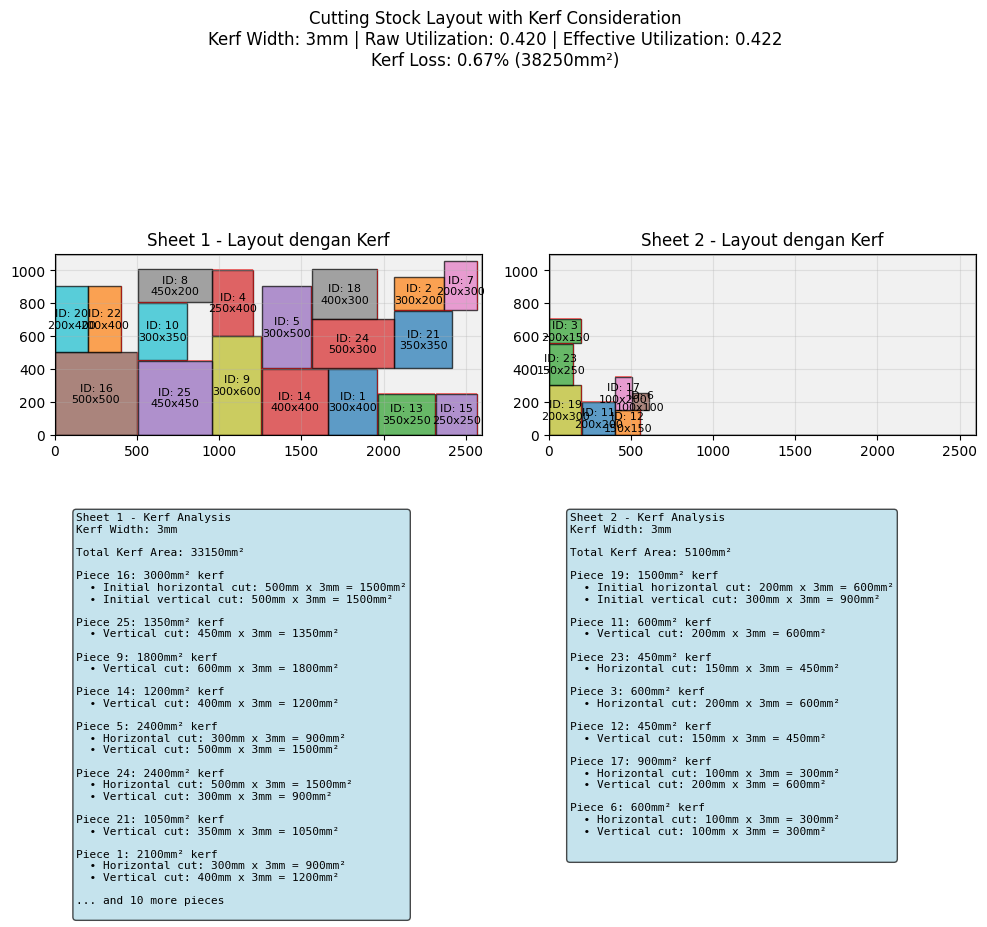


KERF CALCULATION SUMMARY
Kerf Width (Blade Thickness): 3mm
Total Material Used: 2,400,000mm²
Total Kerf Loss: 38,250mm²
Total Sheet Area: 5,720,000mm²

UTILIZATION ANALYSIS:
Raw Utilization (ignoring kerf): 0.420 (42.0%)
Effective Utilization (considering kerf): 0.422 (42.2%)
Kerf Loss Percentage: 0.67%

DETAILED KERF BREAKDOWN BY SHEET:
  Sheet 1: 33,150mm² kerf loss (18 pieces)
  Sheet 2: 5,100mm² kerf loss (7 pieces)


In [ ]:
def run_additional_rl_comparison():
    """Run comparison with the new RL methods"""
    stock_width = 2400
    stock_height = 1200
    kerf_width = 3

    rectangle_sizes = [
        (400, 300, 1), (300, 200, 2), (200, 150, 3), (250, 400, 4), (500, 300, 5),
        (100, 100, 6), (200, 300, 7), (450, 200, 8), (600, 300, 9), (300, 350, 10),
        (200, 200, 11), (150, 150, 12), (350, 250, 13), (400, 400, 14), (250, 250, 15),
        (500, 500, 16), (100, 200, 17), (300, 400, 18), (200, 300, 19), (400, 200, 20),
        (350, 350, 21), (200, 400, 22), (150, 250, 23), (300, 500, 24), (450, 450, 25)
    ]

    rectangles = [Rectangle(width, height, id_num) for width, height, id_num in rectangle_sizes]

    results = compare_all_rl_methods(stock_width, stock_height, rectangles,
                                   episodes=1, kerf_width=kerf_width)

    # # Render best results
    # best_method = max(results.keys(), key=lambda m: results[m]['utilization'])
    # print(f"\nRendering best result from {best_method}:")
    # results[best_method]['env'].render()
    # results[best_method]['env'].print_kerf_summary()

    for method in results.keys():
        print(f"\nRendering result from {method}:")
        results[method]['env'].render()
        results[method]['env'].print_kerf_summary()

    return results

if __name__ == "__main__":
    results = run_additional_rl_comparison()

#Inference Model

In [ ]:
def get_user_inputs_for_inference():
    """Meminta input dari pengguna untuk parameter inferensi."""
    print("Masukkan detail untuk optimasi pemotongan stok:")
    stock_width = int(input("Lebar stok (misal: 2400): "))
    stock_height = int(input("Tinggi stok (misal: 1200): "))
    kerf_width = int(input("Lebar gerigi/pisau (kerf width, misal: 3): "))

    rectangles_input = []
    i = 1
    while True:
        print(f"\n--- Persegi Panjang #{i} ---")
        try:
            rect_w = int(input(f"Lebar persegi panjang #{i} (angka saja): "))
            rect_h = int(input(f"Tinggi persegi panjang #{i} (angka saja): "))
            qty = int(input(f"Kuantitas untuk ({rect_w}x{rect_h}) (angka saja): "))
            if rect_w <= 0 or rect_h <= 0 or qty <= 0:
                print("Dimensi dan kuantitas harus lebih besar dari 0.")
                continue
            rectangles_input.append({'width': rect_w, 'height': rect_h, 'quantity': qty})
            i += 1
        except ValueError:
            print("Input tidak valid. Harap masukkan angka.")
            continue

        add_more = input("Tambah jenis persegi panjang lagi? (y/n): ").strip().lower()
        if add_more != 'y':
            break
    return stock_width, stock_height, kerf_width, rectangles_input

def expand_rectangles_from_input(rectangles_input):
    """Mengubah input persegi panjang dengan kuantitas menjadi list Rectangle individual."""
    expanded_rects = []
    current_id = 1
    for item in rectangles_input:
        for _ in range(item['quantity']):
            expanded_rects.append(Rectangle(item['width'], item['height'], current_id))
            current_id += 1
    return expanded_rects

def load_trained_agent(model_type, state_size, action_size, stock_width_for_env, stock_height_for_env):
    agent = None
    model_path = ""

    if model_type.lower() == 'dqn':
        agent = DQNAgent(state_size, action_size)
        model_path = "cutting_stock_dqn_kerf.keras"
        try:
            agent.load(model_path)
            print(f"Agen DQN berhasil dikonfigurasi setelah memuat model.")
        except Exception as e:
            print(f"Error komprehensif saat memuat dan mengkonfigurasi agen DQN: {e}")
            return None

    elif model_type.lower() == 'policygradient':
        agent = PolicyGradientAgent(state_size, action_size)
        model_path = "/content/cutting_stock_policygradient_kerf.keras"
        try:
            if agent.model is None:
                agent.model = agent._build_model()
            agent.load(model_path)
            print(f"Model Policy Gradient dimuat dari {model_path}")
        except Exception as e:
            print(f"Error memuat model Policy Gradient: {e}. Pastikan model sudah dilatih dan disimpan.")
            return None

    elif model_type.lower() == 'a2c':
        agent = A2CAgent(state_size, action_size)
        actor_model_path = "/content/cutting_stock_a2c_kerf_actor.keras"
        critic_model_path = "/content/cutting_stock_a2c_kerf_critic.keras"
        try:
            agent.load(actor_model_path, critic_model_path)
            print(f"Model A2C (actor dari {actor_model_path}, critic dari {critic_model_path}) berhasil dimuat.")
        except Exception as e:
            print(f"Error memuat model A2C: {e}. Pastikan model sudah dilatih dan disimpan.")
            return None
    else:
        print(f"Tipe model tidak dikenal: {model_type}")
        return None
    return agent

def run_inference(env, agent, model_type, max_positions_inference, original_rectangles_input):
    """Menjalankan proses inferensi menggunakan agen yang sudah dimuat."""
    state = env.reset()
    done = False
    steps = 0

    if model_type.lower() == 'dqn' and agent is not None:
        agent.epsilon = 0.0

    print("\nMemulai proses penempatan item (inferensi)...")

    total_original_pieces = sum(item['quantity'] for item in original_rectangles_input)
    max_steps_limit = total_original_pieces + env.max_sheets * total_original_pieces

    while not done:
        valid_actions_tuples = get_valid_actions(env)
        if len(env.rectangles) == 0:
            print("Semua item berhasil ditempatkan.")
            done = True
            break

        if not valid_actions_tuples:
            if env.current_sheet_idx < env.max_sheets - 1 and any(r.can_fit(env.stock_width, env.stock_height) for r in env.rectangles):
                print("Tidak ada posisi valid di sheet saat ini, inisialisasi sheet baru.")
                env._initialize_new_sheet()
                state = env._get_state()
                continue
            else:
                print("Tidak ada posisi valid tersisa dan tidak bisa menambah sheet baru, atau item tersisa terlalu besar.")
                done = True
                break

        valid_action_indices = []
        for pos_idx, rotation in valid_actions_tuples:
            action_idx = pos_idx * 2 + rotation
            if action_idx < agent.action_size :
                 valid_action_indices.append(action_idx)

        if not valid_action_indices:
            print("Tidak ada indeks aksi valid yang bisa dipilih dari state saat ini.")
            if env.current_sheet_idx < env.max_sheets - 1 and any(r.can_fit(env.stock_width, env.stock_height) for r in env.rectangles):
                print("Tidak ada posisi valid di sheet saat ini (setelah filter indeks), inisialisasi sheet baru.")
                env._initialize_new_sheet()
                state = env._get_state()
                continue
            else:
                print("Tidak bisa melanjutkan, tidak ada aksi valid (setelah filter) dan tidak bisa ganti sheet.")
                done = True
                break

        if model_type.lower() == 'dqn':
            action_idx = agent.act(state, valid_action_indices)
        elif model_type.lower() == 'policygradient':
            action_idx = agent.act(state, valid_action_indices)
        elif model_type.lower() == 'a2c':
            action_idx, _ = agent.act(state, valid_action_indices)
        else:
            print("Error: Tipe model tidak didukung untuk inferensi.")
            done = True
            break

        action_tuple_for_env = action_to_tuple(action_idx, max_positions_inference)

        next_state, reward, done_env_step, info = env.step(action_tuple_for_env)

        state = next_state
        steps += 1

        if steps > max_steps_limit:
             print(f"Batas langkah maksimum ({max_steps_limit}) tercapai.")
             done = True
             break

        done = done_env_step

        if steps % 10 == 0:
             print(f"Step {steps}: Placed item ID {info.get('piece_id')}. Remaining items: {len(env.rectangles)}")

    print("Inferensi selesai.")
    return env

def main_inference():
    stock_w, stock_h, kerf_w, rectangles_input_with_qty = get_user_inputs_for_inference()
    rectangles_to_place = expand_rectangles_from_input(rectangles_input_with_qty)

    if not rectangles_to_place:
        print("Tidak ada persegi panjang untuk ditempatkan. Keluar.")
        return

    print("\nPilih model untuk inferensi:")
    print("1. DQN")
    print("2. PolicyGradient")
    print("3. A2C")
    model_choice = input("Masukkan nomor model (1-3): ")
    model_type_map = {'1': 'DQN', '2': 'PolicyGradient', '3': 'A2C'}
    chosen_model_type = model_type_map.get(model_choice)

    if not chosen_model_type:
        print("Pilihan model tidak valid. Keluar.")
        return

    grid_s = 10
    state_size = (stock_w // grid_s) * (stock_h // grid_s) * 2 + 3
    max_positions_for_decode_env = (stock_w // grid_s) * (stock_h // grid_s)
    action_s = max_positions_for_decode_env * 2


    print(f"Menginisialisasi agen {chosen_model_type} dengan state_size={state_size}, action_size={action_s}")
    loaded_agent = load_trained_agent(chosen_model_type, state_size, action_s, stock_w, stock_h)

    if not loaded_agent:
        print("Gagal memuat agen. Keluar.")
        return

    inference_env = CuttingStockEnvironment(stock_w, stock_h, rectangles_to_place, kerf_width=kerf_w)


    start_time = time.time()
    final_env_state = run_inference(inference_env, loaded_agent, chosen_model_type, max_positions_for_decode_env, rectangles_input_with_qty)
    inference_time = time.time() - start_time

    print(f"\n--- Hasil Inferensi Menggunakan Model {chosen_model_type} ---")
    final_env_state.render()
    final_env_state.print_kerf_summary()
    print(f"Waktu inferensi: {inference_time:.2f} detik")

    if len(final_env_state.rectangles) > 0:
        print(f"\nPERHATIAN: {len(final_env_state.rectangles)} item tidak berhasil ditempatkan.")
        print("Item yang tersisa:")
        for r in final_env_state.rectangles:
            print(f"  - ID {r.id}: {r.width}x{r.height}")

Masukkan detail untuk optimasi pemotongan stok:
Lebar stok (misal: 2400): 2400
Tinggi stok (misal: 1200): 1200
Lebar gerigi/pisau (kerf width, misal: 3): 3

--- Persegi Panjang #1 ---
Lebar persegi panjang #1 (angka saja): 200
Tinggi persegi panjang #1 (angka saja): 300
Kuantitas untuk (200x300) (angka saja): 7
Tambah jenis persegi panjang lagi? (y/n): y

--- Persegi Panjang #2 ---
Lebar persegi panjang #2 (angka saja): 400
Tinggi persegi panjang #2 (angka saja): 600
Kuantitas untuk (400x600) (angka saja): 8
Tambah jenis persegi panjang lagi? (y/n): n

Pilih model untuk inferensi:
1. DQN
2. PolicyGradient
3. A2C
Masukkan nomor model (1-3): 2
Menginisialisasi agen PolicyGradient dengan state_size=57603, action_size=57600
Mencoba memuat model Policy Gradient dari: /content/cutting_stock_policygradient_kerf.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Policy Gradient berhasil dimuat dari /content/cutting_stock_policygradient_kerf.keras
Model Policy Gradient dimuat dari /content/cutting_stock_policygradient_kerf.keras

Memulai proses penempatan item (inferensi)...
Step 10: Placed item ID None. Remaining items: 5
Inferensi selesai.

--- Hasil Inferensi Menggunakan Model PolicyGradient ---


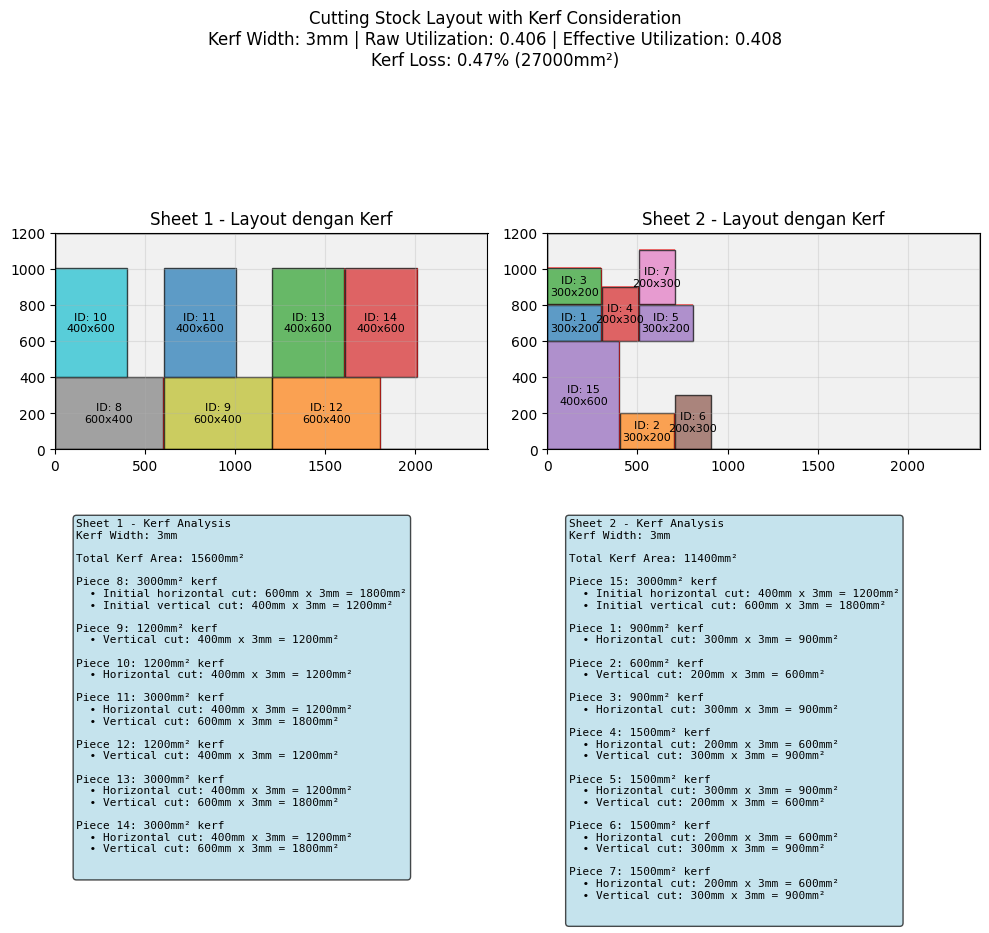


KERF CALCULATION SUMMARY
Kerf Width (Blade Thickness): 3mm
Total Material Used: 2,340,000mm²
Total Kerf Loss: 27,000mm²
Total Sheet Area: 5,760,000mm²

UTILIZATION ANALYSIS:
Raw Utilization (ignoring kerf): 0.406 (40.6%)
Effective Utilization (considering kerf): 0.408 (40.8%)
Kerf Loss Percentage: 0.47%

DETAILED KERF BREAKDOWN BY SHEET:
  Sheet 1: 15,600mm² kerf loss (7 pieces)
  Sheet 2: 11,400mm² kerf loss (8 pieces)
Waktu inferensi: 11.37 detik


In [ ]:
if __name__ == "__main__":
    main_inference()

#Detail Compare HBL and DQN

CUTTING STOCK OPTIMIZATION WITH KERF CONSIDERATION
Stock Sheet Size: 2400mm x 1200mm
Kerf Width (Blade Thickness): 3mm
Number of pieces to cut: 25
Total area of pieces: 2,400,000mm²

BOTTOM-LEFT HEURISTIC WITH KERF


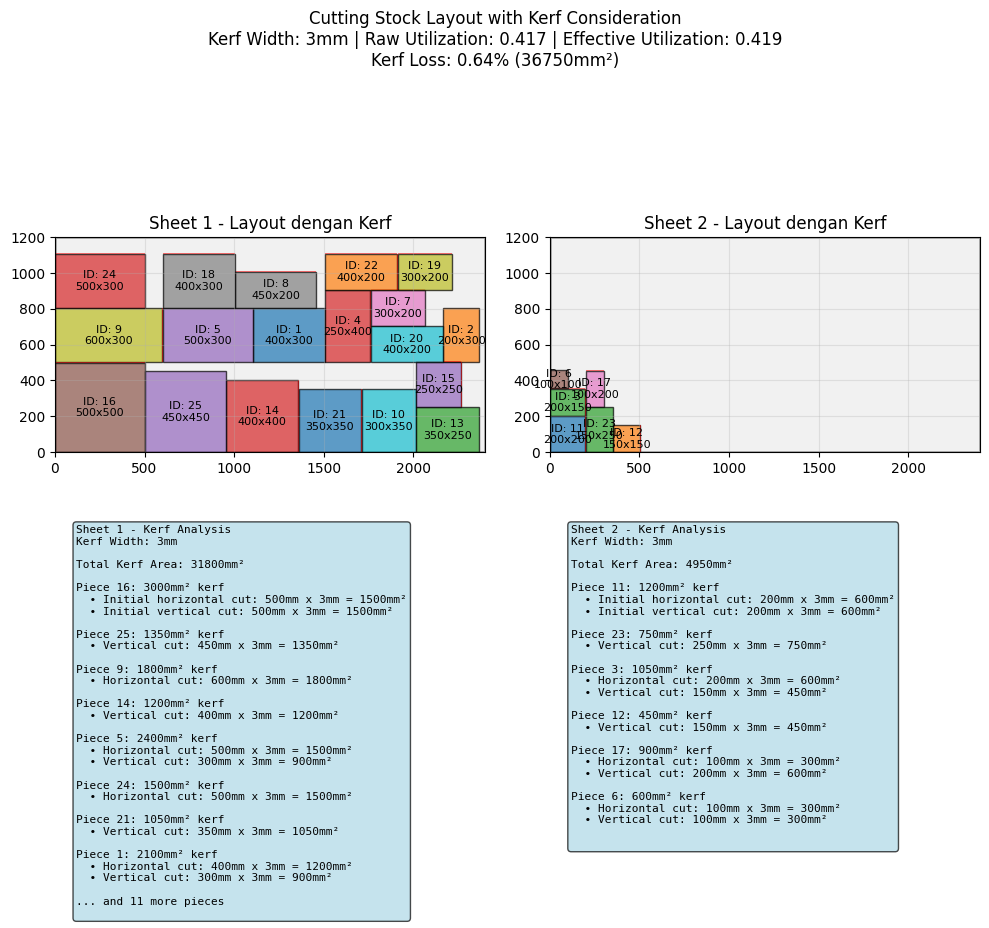


KERF CALCULATION SUMMARY
Kerf Width (Blade Thickness): 3mm
Total Material Used: 2,400,000mm²
Total Kerf Loss: 36,750mm²
Total Sheet Area: 5,760,000mm²

UTILIZATION ANALYSIS:
Raw Utilization (ignoring kerf): 0.417 (41.7%)
Effective Utilization (considering kerf): 0.419 (41.9%)
Kerf Loss Percentage: 0.64%

DETAILED KERF BREAKDOWN BY SHEET:
  Sheet 1: 31,800mm² kerf loss (19 pieces)
  Sheet 2: 4,950mm² kerf loss (6 pieces)
Computation time: 15.10 seconds

KERF WIDTH COMPARISON ANALYSIS
Comparing different kerf widths...

Testing kerf width: 3mm
  Raw utilization: 0.417
  Effective utilization: 0.419
  Kerf loss: 0.64%


<ipython-input-12-b42a43683b58>:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-^" (-> color='g'). The keyword argument will take precedence.
  ax2.plot(kerf_widths, kerf_losses, 'g-^', linewidth=2, color='orange')
<ipython-input-12-b42a43683b58>:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-d" (-> color='r'). The keyword argument will take precedence.
  ax4.plot(kerf_widths, kerf_areas, 'r-d', linewidth=2, color='red')


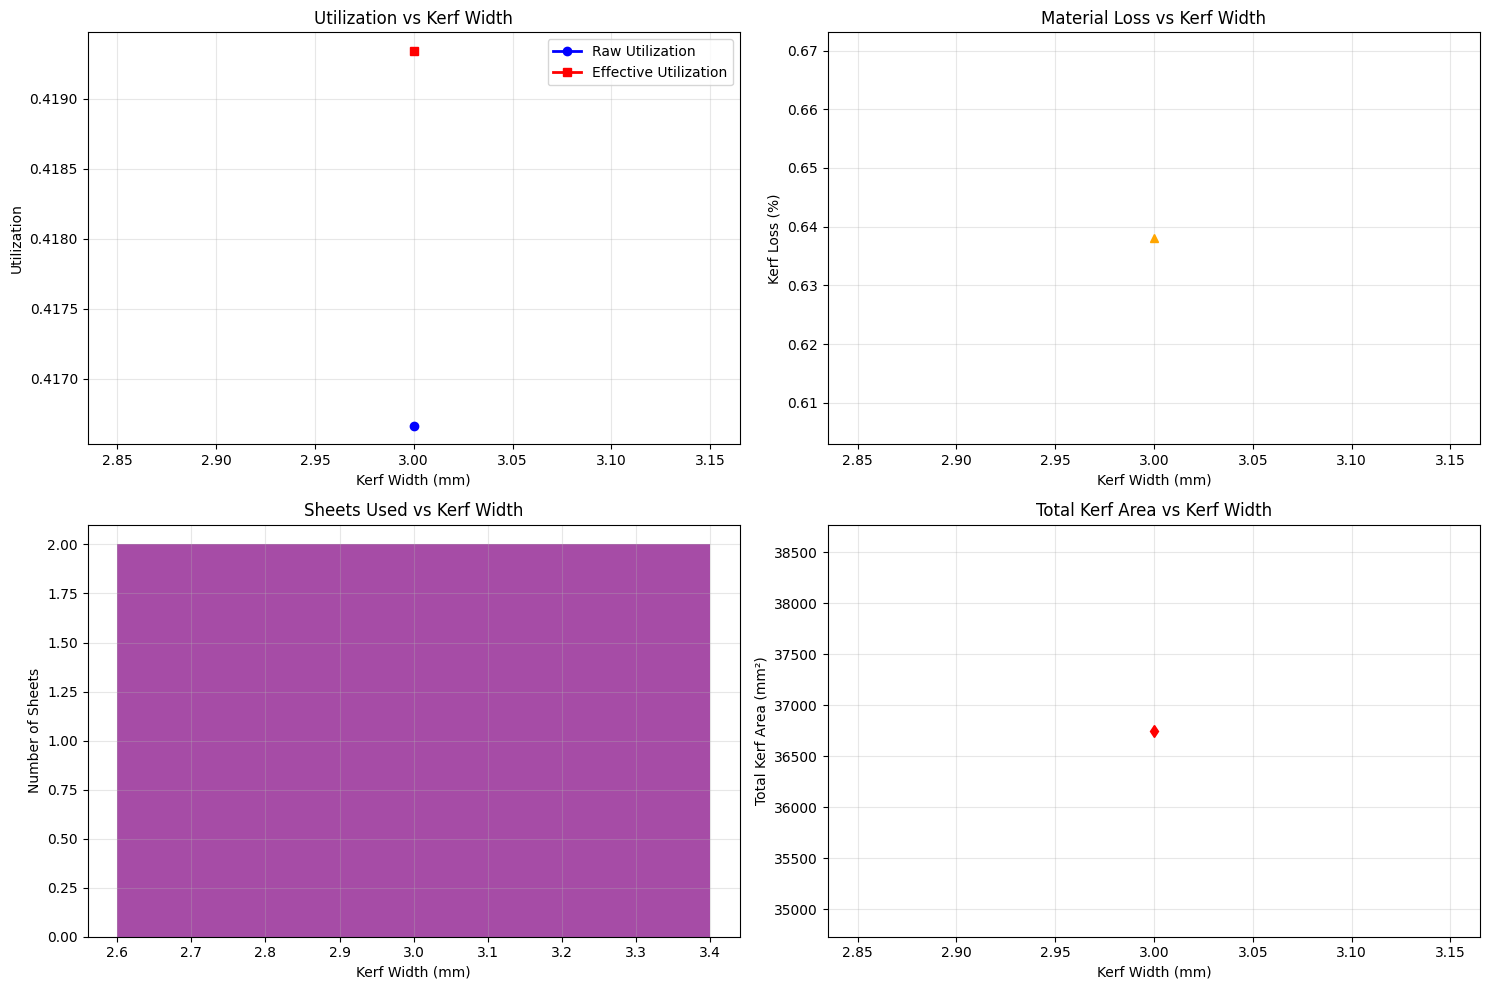


KERF WIDTH COMPARISON TABLE:
------------------------------------------------------------------------------------------
Kerf   Raw Util   Eff Util   Kerf Loss    Kerf Area    Sheets  
(mm)   (%)        (%)        (%)          (mm²)        Used    
------------------------------------------------------------------------------------------
3      41.7       41.9       0.64         36750        2       

REINFORCEMENT LEARNING WITH KERF
Training RL model with kerf consideration...
Episode: 1/10, Steps: 25, Reward: 14.30, Utilization: 0.42, Kerf Loss: 38850mm², Epsilon: 1.00
Episode: 2/10, Steps: 25, Reward: 16.85, Utilization: 0.84, Kerf Loss: 37950mm², Epsilon: 0.99
Episode: 3/10, Steps: 25, Reward: 16.79, Utilization: 0.85, Kerf Loss: 40500mm², Epsilon: 0.99
Episode: 4/10, Steps: 25, Reward: 17.00, Utilization: 0.85, Kerf Loss: 42450mm², Epsilon: 0.99
Episode: 5/10, Steps: 25, Reward: 16.66, Utilization: 0.84, Kerf Loss: 38700mm², Epsilon: 0.98
Episode: 6/10, Steps: 25, Reward: 16.93, U

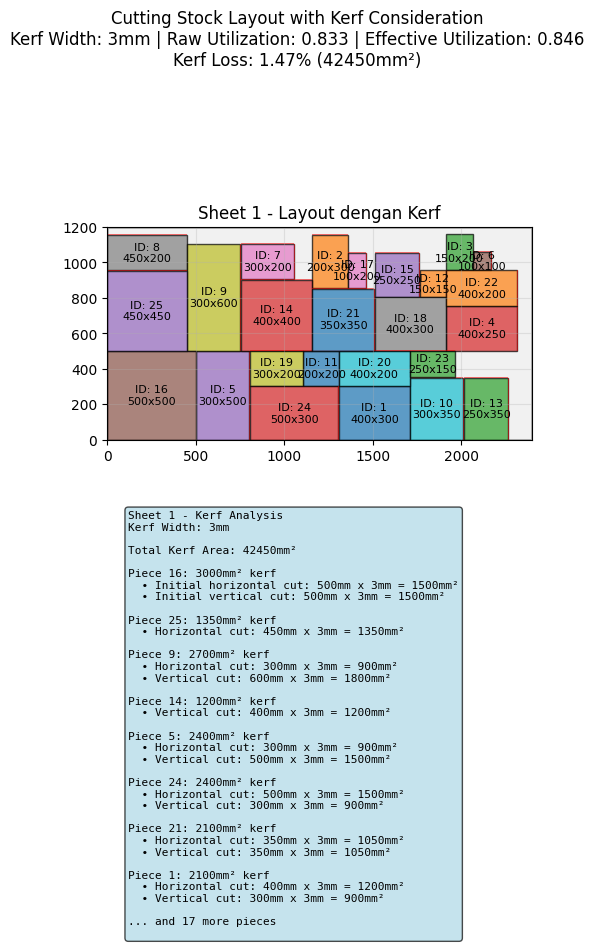


KERF CALCULATION SUMMARY
Kerf Width (Blade Thickness): 3mm
Total Material Used: 2,400,000mm²
Total Kerf Loss: 42,450mm²
Total Sheet Area: 2,880,000mm²

UTILIZATION ANALYSIS:
Raw Utilization (ignoring kerf): 0.833 (83.3%)
Effective Utilization (considering kerf): 0.846 (84.6%)
Kerf Loss Percentage: 1.47%

DETAILED KERF BREAKDOWN BY SHEET:
  Sheet 1: 42,450mm² kerf loss (25 pieces)
Training time: 211.68 seconds
DQN model with kerf consideration saved.

FINAL COMPARISON


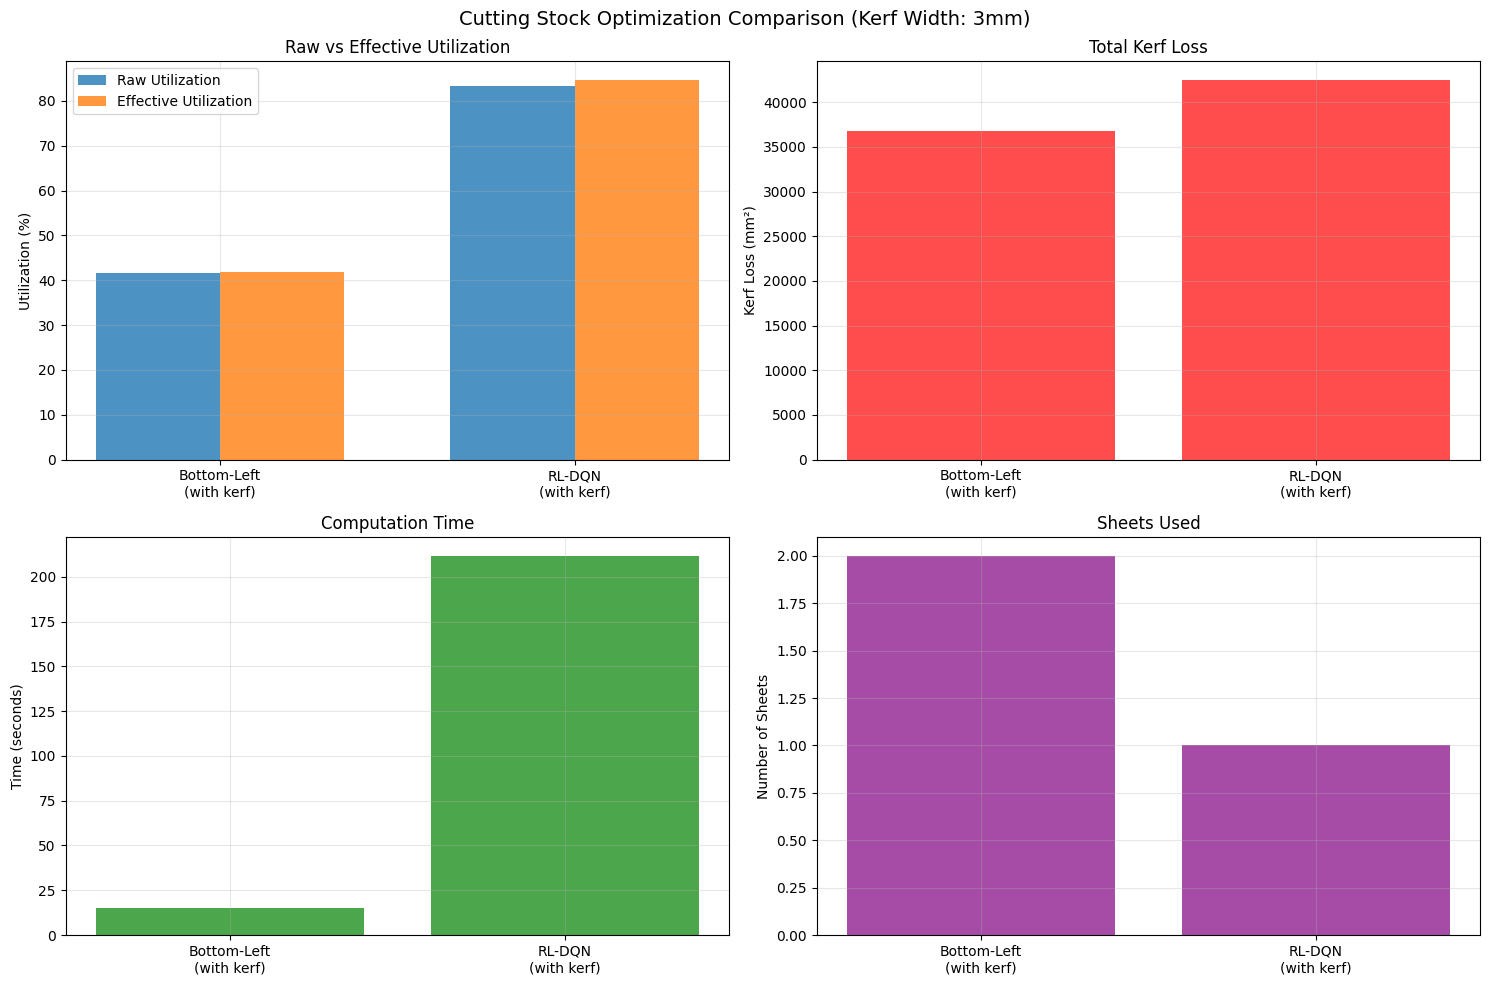


SUMMARY:
Kerf width used: 3mm
Bottom-Left Method:
  - Raw utilization: 0.417 (41.7%)
  - Effective utilization: 0.419 (41.9%)
  - Kerf loss: 36,750mm²
  - Sheets used: 2
RL-DQN Method:
  - Raw utilization: 0.833 (83.3%)
  - Effective utilization: 0.846 (84.6%)
  - Kerf loss: 42,450mm²
  - Sheets used: 1

KERF IMPACT:
Material loss due to cutting: 0.64% of total sheet area
This equals 0.037 square meters of wasted material


In [ ]:
if __name__ == "__main__":
    stock_width = 2400
    stock_height = 1200

    kerf_width = 3

    rectangle_sizes = [
        (400, 300, 1), (300, 200, 2), (200, 150, 3), (250, 400, 4), (500, 300, 5),
        (100, 100, 6), (200, 300, 7), (450, 200, 8), (600, 300, 9), (300, 350, 10),
        (200, 200, 11), (150, 150, 12), (350, 250, 13), (400, 400, 14), (250, 250, 15),
        (500, 500, 16), (100, 200, 17), (300, 400, 18), (200, 300, 19), (400, 200, 20),
        (350, 350, 21), (200, 400, 22), (150, 250, 23), (300, 500, 24), (450, 450, 25)
    ]

    rectangles = [Rectangle(width, height, id_num) for width, height, id_num in rectangle_sizes]

    print("=" * 80)
    print("CUTTING STOCK OPTIMIZATION WITH KERF CONSIDERATION")
    print("=" * 80)
    print(f"Stock Sheet Size: {stock_width}mm x {stock_height}mm")
    print(f"Kerf Width (Blade Thickness): {kerf_width}mm")
    print(f"Number of pieces to cut: {len(rectangles)}")

    total_piece_area = sum(r.get_area() for r in rectangles)
    print(f"Total area of pieces: {total_piece_area:,}mm²")

    print("\n" + "=" * 50)
    print("BOTTOM-LEFT HEURISTIC WITH KERF")
    print("=" * 50)

    start_time = time.time()
    bl_env = bottom_left_packing(stock_width, stock_height, rectangles, kerf_width=kerf_width)
    bl_time = time.time() - start_time

    bl_env.render()
    bl_env.print_kerf_summary()
    print(f"Computation time: {bl_time:.2f} seconds")

    print("\n" + "=" * 50)
    print("KERF WIDTH COMPARISON ANALYSIS")
    print("=" * 50)

    kerf_comparison = compare_kerf_widths(stock_width, stock_height, rectangles,
                                        kerf_widths=[3])

    plot_kerf_comparison(kerf_comparison)

    print("\nKERF WIDTH COMPARISON TABLE:")
    print("-" * 90)
    print(f"{'Kerf':<6} {'Raw Util':<10} {'Eff Util':<10} {'Kerf Loss':<12} {'Kerf Area':<12} {'Sheets':<8}")
    print(f"{'(mm)':<6} {'(%)':<10} {'(%)':<10} {'(%)':<12} {'(mm²)':<12} {'Used':<8}")
    print("-" * 90)

    for result in kerf_comparison:
        print(f"{result['kerf_width']:<6} "
              f"{result['raw_utilization']*100:<10.1f} "
              f"{result['effective_utilization']*100:<10.1f} "
              f"{result['kerf_loss_percentage']:<12.2f} "
              f"{result['total_kerf_area']:<12.0f} "
              f"{result['sheets_used']:<8}")

    print("\n" + "=" * 50)
    print("REINFORCEMENT LEARNING WITH KERF")
    print("=" * 50)
    print("Training RL model with kerf consideration...")

    rectangles = [Rectangle(width, height, id_num) for width, height, id_num in rectangle_sizes]
    start_time = time.time()
    best_env, agent = train_cutting_stock_rl(stock_width, stock_height, rectangles,
                                           episodes=10, kerf_width=kerf_width)
    training_time = time.time() - start_time

    best_env.render()
    best_env.print_kerf_summary()
    print(f"Training time: {training_time:.2f} seconds")

    agent.save("cutting_stock_kerf_dqn.keras")
    print("DQN model with kerf consideration saved.")

    print("\n" + "=" * 50)
    print("FINAL COMPARISON")
    print("=" * 50)

    methods = ['Bottom-Left\n(with kerf)', 'RL-DQN\n(with kerf)']

    bl_raw_util = bl_env.total_area_used / bl_env.total_sheet_area
    bl_eff_util = bl_env.total_area_used / (bl_env.total_sheet_area - bl_env.total_kerf_area)

    rl_raw_util = best_env.total_area_used / best_env.total_sheet_area
    rl_eff_util = best_env.total_area_used / (best_env.total_sheet_area - best_env.total_kerf_area)

    raw_utils = [bl_raw_util, rl_raw_util]
    eff_utils = [bl_eff_util, rl_eff_util]
    kerf_losses = [bl_env.total_kerf_area, best_env.total_kerf_area]
    times = [bl_time, training_time]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    x = np.arange(len(methods))
    width = 0.35

    ax1.bar(x - width/2, [u*100 for u in raw_utils], width, label='Raw Utilization', alpha=0.8)
    ax1.bar(x + width/2, [u*100 for u in eff_utils], width, label='Effective Utilization', alpha=0.8)
    ax1.set_ylabel('Utilization (%)')
    ax1.set_title('Raw vs Effective Utilization')
    ax1.set_xticks(x)
    ax1.set_xticklabels(methods)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.bar(methods, kerf_losses, color='red', alpha=0.7)
    ax2.set_ylabel('Kerf Loss (mm²)')
    ax2.set_title('Total Kerf Loss')
    ax2.grid(True, alpha=0.3)

    ax3.bar(methods, times, color='green', alpha=0.7)
    ax3.set_ylabel('Time (seconds)')
    ax3.set_title('Computation Time')
    ax3.grid(True, alpha=0.3)

    sheets_used = [len(bl_env.sheets), len(best_env.sheets)]
    ax4.bar(methods, sheets_used, color='purple', alpha=0.7)
    ax4.set_ylabel('Number of Sheets')
    ax4.set_title('Sheets Used')
    ax4.grid(True, alpha=0.3)

    plt.suptitle(f'Cutting Stock Optimization Comparison (Kerf Width: {kerf_width}mm)', fontsize=14)
    plt.tight_layout()
    plt.show()

    print(f"\nSUMMARY:")
    print(f"Kerf width used: {kerf_width}mm")
    print(f"Bottom-Left Method:")
    print(f"  - Raw utilization: {bl_raw_util:.3f} ({bl_raw_util*100:.1f}%)")
    print(f"  - Effective utilization: {bl_eff_util:.3f} ({bl_eff_util*100:.1f}%)")
    print(f"  - Kerf loss: {bl_env.total_kerf_area:,.0f}mm²")
    print(f"  - Sheets used: {len(bl_env.sheets)}")

    print(f"RL-DQN Method:")
    print(f"  - Raw utilization: {rl_raw_util:.3f} ({rl_raw_util*100:.1f}%)")
    print(f"  - Effective utilization: {rl_eff_util:.3f} ({rl_eff_util*100:.1f}%)")
    print(f"  - Kerf loss: {best_env.total_kerf_area:,.0f}mm²")
    print(f"  - Sheets used: {len(best_env.sheets)}")

    print(f"\nKERF IMPACT:")
    total_sheet_area = bl_env.total_sheet_area
    kerf_impact = 100 * bl_env.total_kerf_area / total_sheet_area
    print(f"Material loss due to cutting: {kerf_impact:.2f}% of total sheet area")
    print(f"This equals {bl_env.total_kerf_area/1000000:.3f} square meters of wasted material")

#Another Algo

In [ ]:
pip install gym matplotlib numpy

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

class Cutting2DEnv(gym.Env):
    def __init__(self, board_size=(100, 100), pieces=None):
        super(Cutting2DEnv, self).__init__()
        self.board_width, self.board_height = board_size
        self.pieces = pieces if pieces is not None else [(30, 20), (50, 10), (20, 20), (10, 10), (40, 30)]
        self.max_pieces = len(self.pieces)
        self.current_piece_index = 0

        self.observation_space = spaces.Dict({
            'board': spaces.Box(low=0, high=1, shape=(self.board_height, self.board_width), dtype=np.int8),
            'current_piece': spaces.Box(low=0, high=max(self.board_width, self.board_height), shape=(2,), dtype=np.int32)
        })

        self.action_space = spaces.Box(low=0, high=max(self.board_width, self.board_height), shape=(2,), dtype=np.int32)

        self.reset()

    def reset(self):
        self.board = np.zeros((self.board_height, self.board_width), dtype=np.int8)
        self.current_piece_index = 0
        return self._get_obs()

    def _get_obs(self):
        if self.current_piece_index < self.max_pieces:
             current_piece_info = np.array(self.pieces[self.current_piece_index])
        else:
             current_piece_info = np.array([0, 0], dtype=np.int32)

        return {
            'board': self.board.copy(),
            'current_piece': current_piece_info
        }

    def step(self, action):
        x, y = action
        x, y = int(x), int(y)
        done = False
        reward = 0
        info = {}

        if self.current_piece_index < self.max_pieces:
            w, h = self.pieces[self.current_piece_index]

            if self._can_place(x, y, w, h):
                self.board[y:y+h, x:x+w] = 1
                reward = w * h
                self.current_piece_index += 1

                if self.current_piece_index >= self.max_pieces:
                    done = True
            else:
                reward = -10

        else:
             done = True
             reward = 0
             info["message"] = "No pieces left to place"

        next_obs = self._get_obs()

        return next_obs, reward, done, info

    def _can_place(self, x, y, w, h):
        if x < 0 or y < 0 or x + w > self.board_width or y + h > self.board_height:
            return False
        return np.all(self.board[y:y+h, x:x+w] == 0)

    def render(self, mode='human'):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(self.board == 0, cmap="gray_r", extent=[0, self.board_width, 0, self.board_height])
        ax.set_title("Cutting 2D Board")
        ax.set_xlim(0, self.board_width)
        ax.set_ylim(0, self.board_height)
        ax.set_aspect('equal')
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.show()

Placed piece at (29, 25), reward: 600, done: False


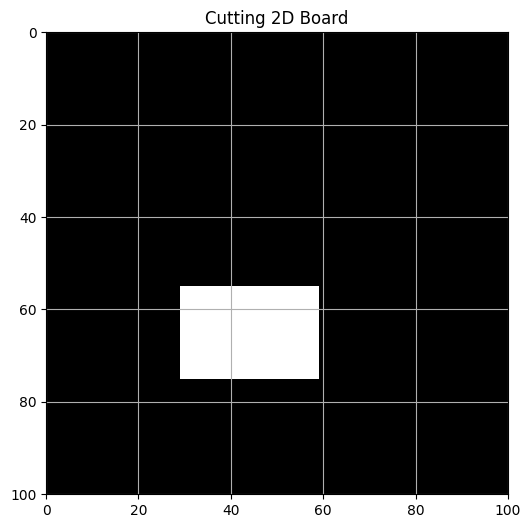

Placed piece at (12, 35), reward: -10, done: False


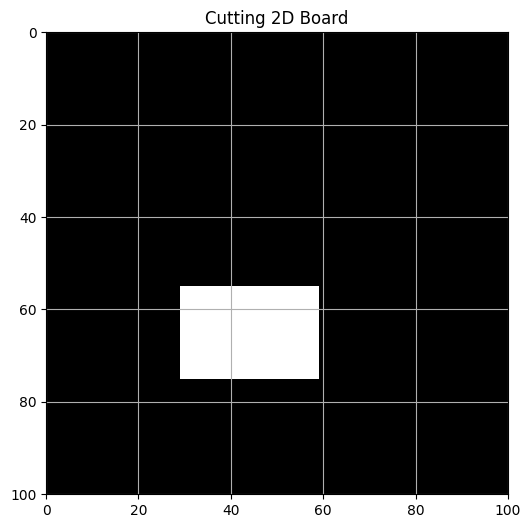

Placed piece at (0, 34), reward: -10, done: False


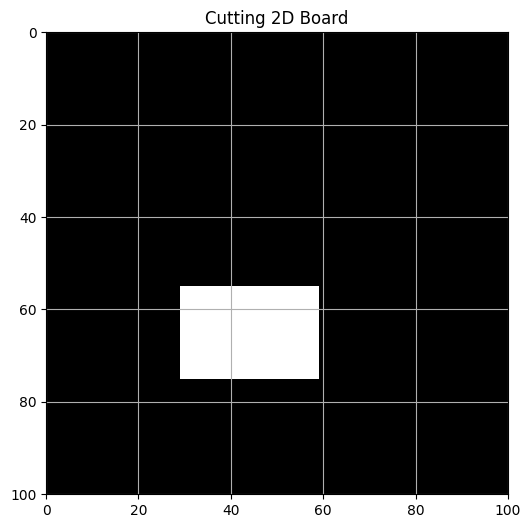

Placed piece at (1, 73), reward: 500, done: False


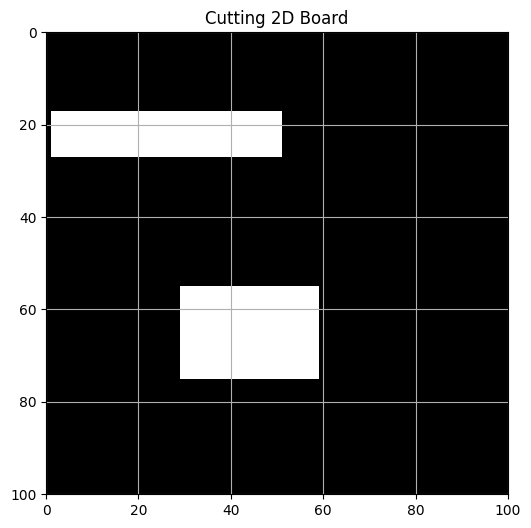

Placed piece at (71, 53), reward: 400, done: False


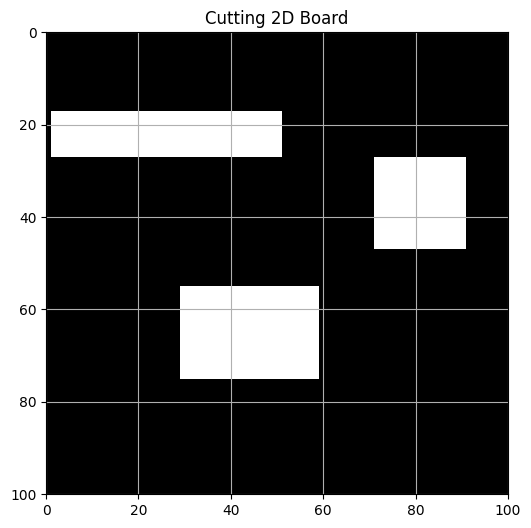

Placed piece at (46, 18), reward: -10, done: False


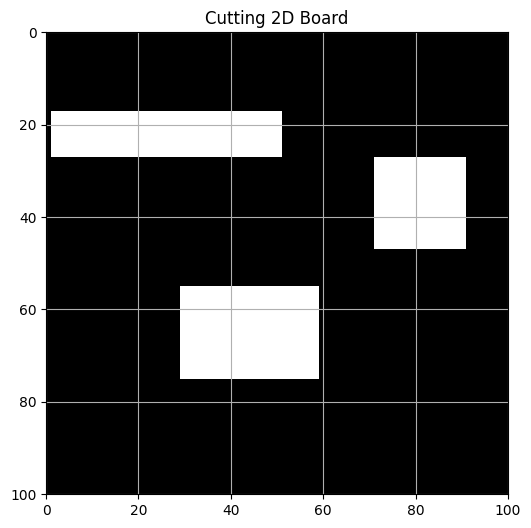

Placed piece at (7, 2), reward: 100, done: False


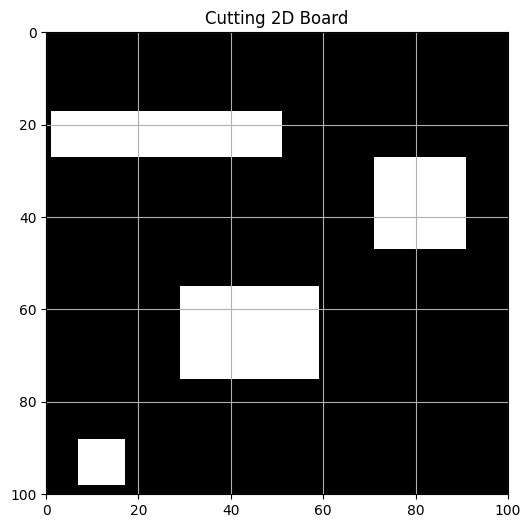

Placed piece at (54, 0), reward: -10, done: False


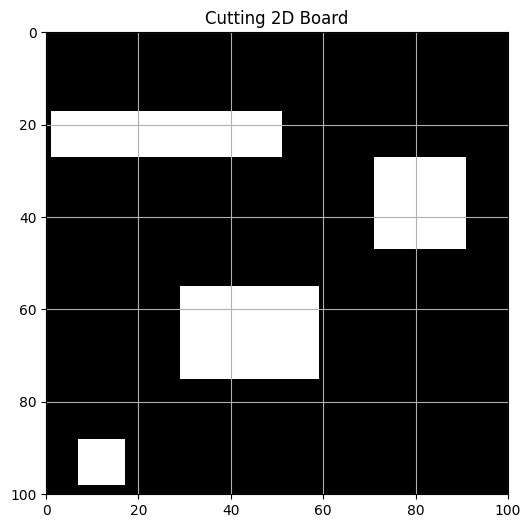

Placed piece at (31, 41), reward: -10, done: False


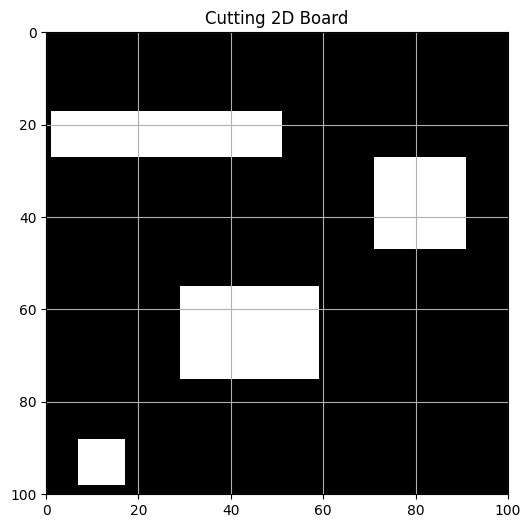

Placed piece at (6, 47), reward: -10, done: False


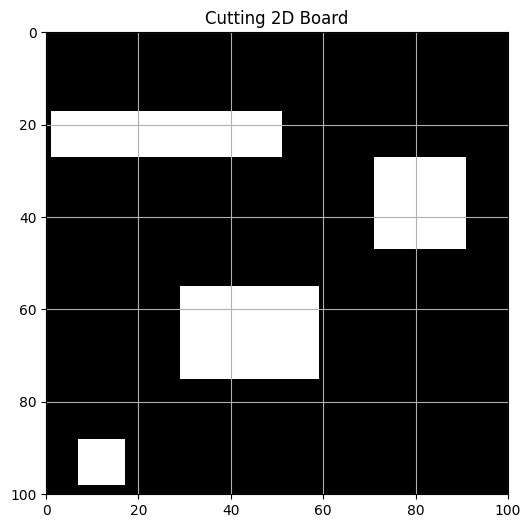

Placed piece at (26, 27), reward: -10, done: False


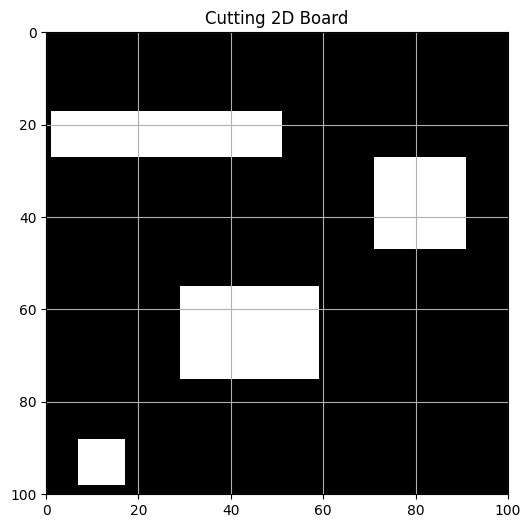

Placed piece at (8, 39), reward: -10, done: False


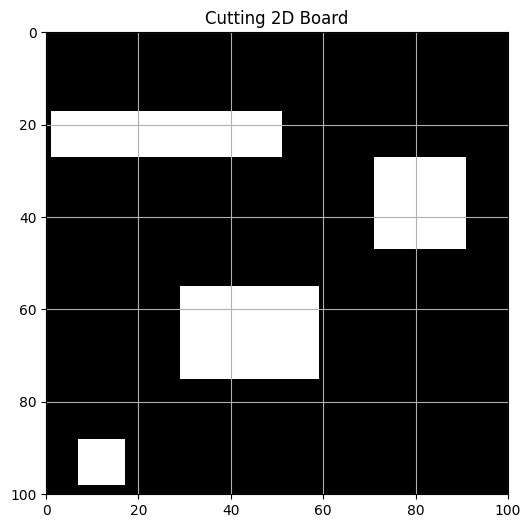

Placed piece at (45, 27), reward: -10, done: False


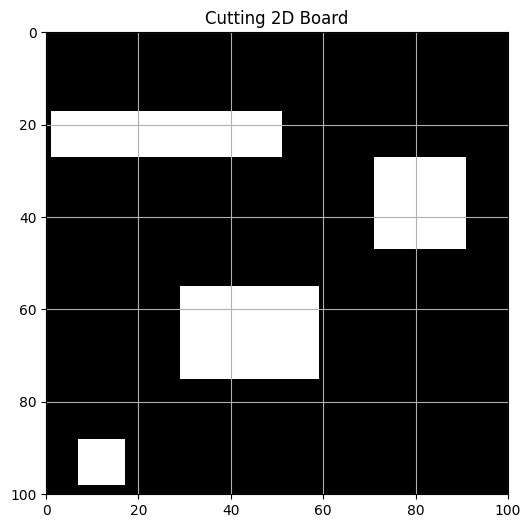

Placed piece at (24, 65), reward: -10, done: False


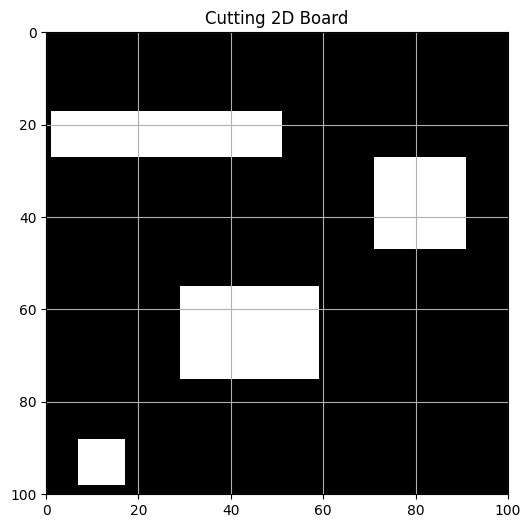

Placed piece at (27, 31), reward: -10, done: False


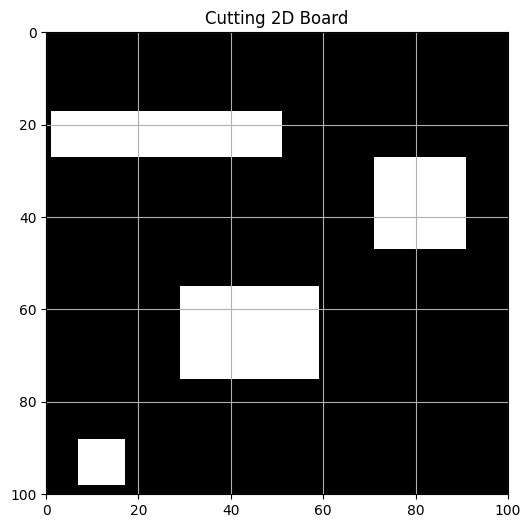

Placed piece at (57, 19), reward: -10, done: False


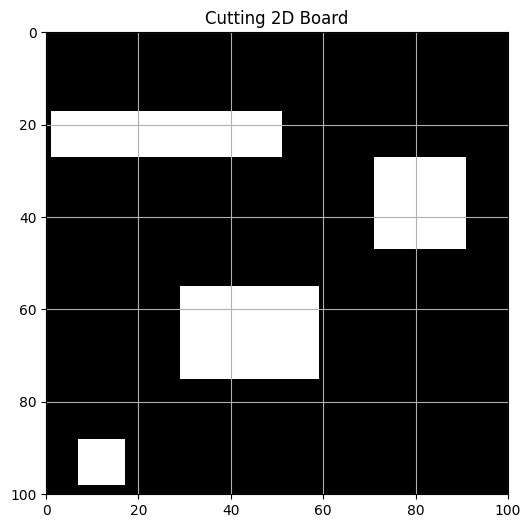

Placed piece at (54, 62), reward: -10, done: False


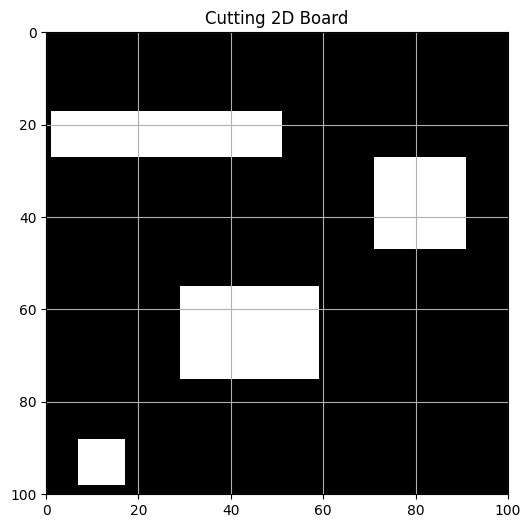

Placed piece at (18, 46), reward: -10, done: False


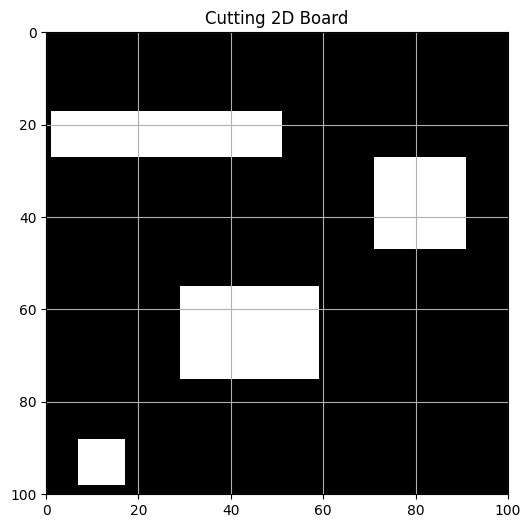

Placed piece at (38, 27), reward: -10, done: False


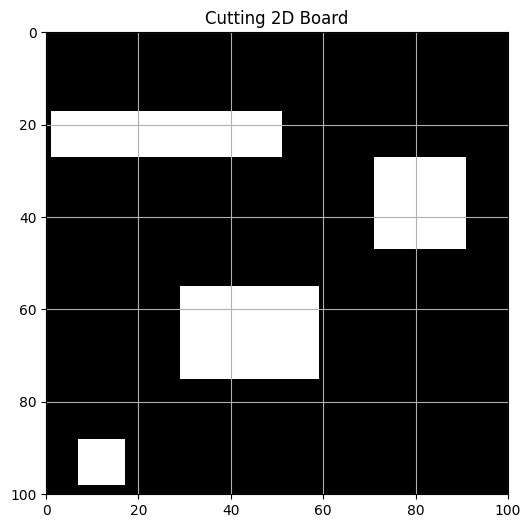

Placed piece at (16, 16), reward: -10, done: False


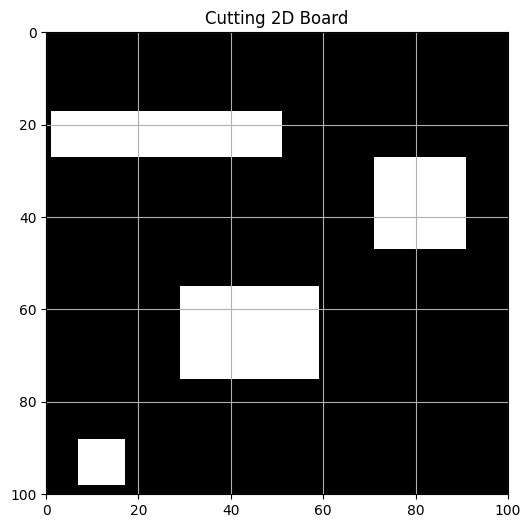

Placed piece at (7, 55), reward: -10, done: False


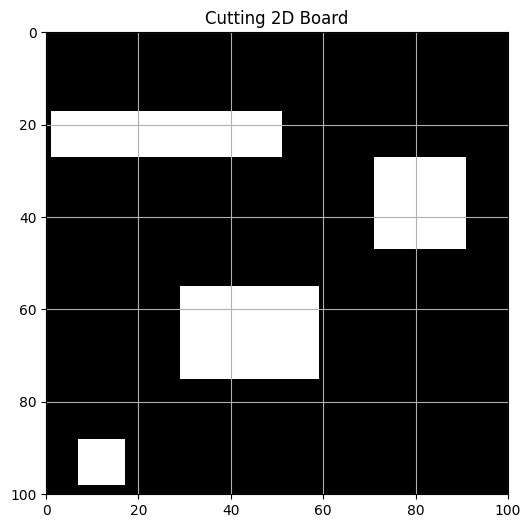

Placed piece at (42, 26), reward: -10, done: False


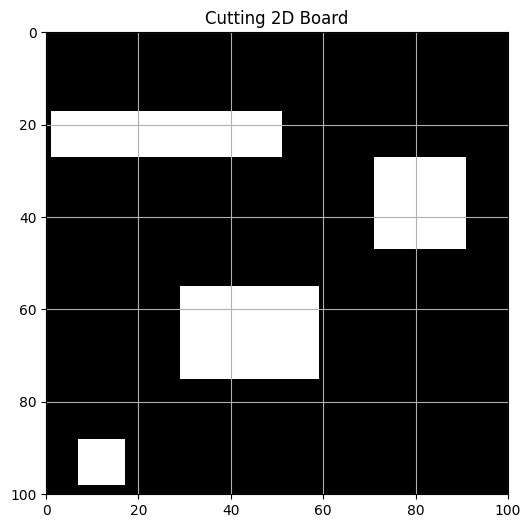

Placed piece at (45, 58), reward: -10, done: False


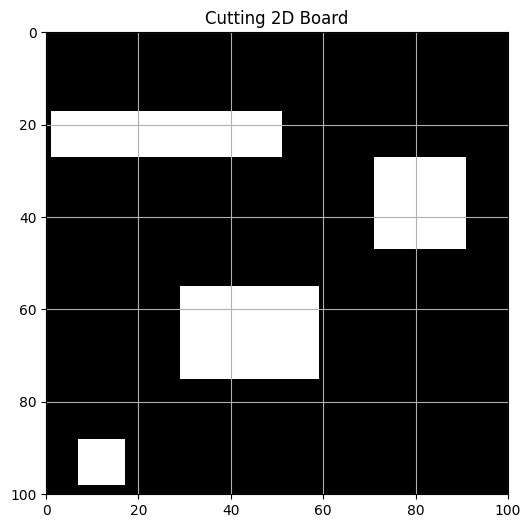

Placed piece at (43, 53), reward: -10, done: False


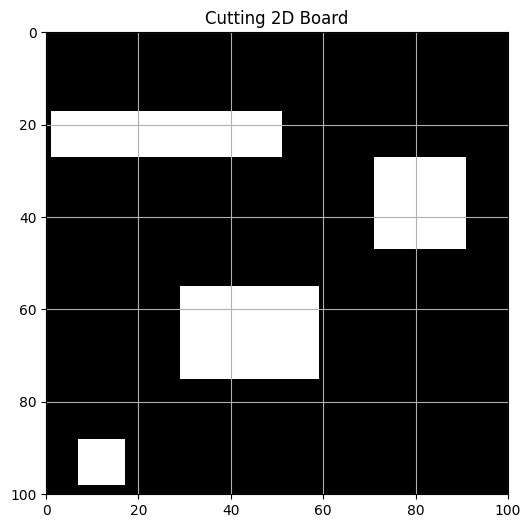

Placed piece at (47, 65), reward: -10, done: False


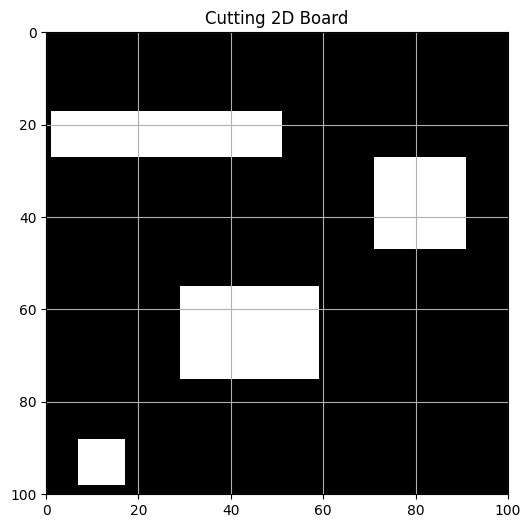

Placed piece at (49, 23), reward: -10, done: False


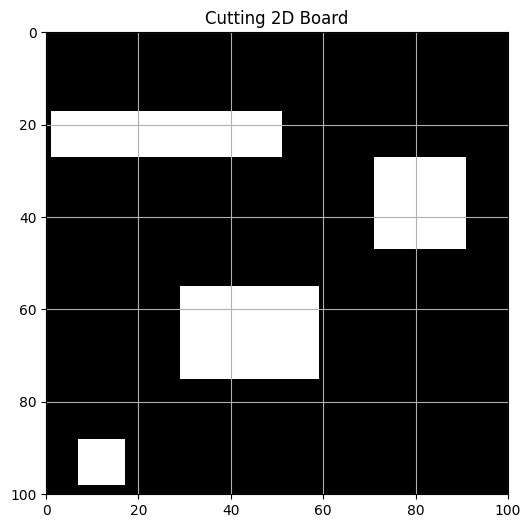

Placed piece at (49, 68), reward: -10, done: False


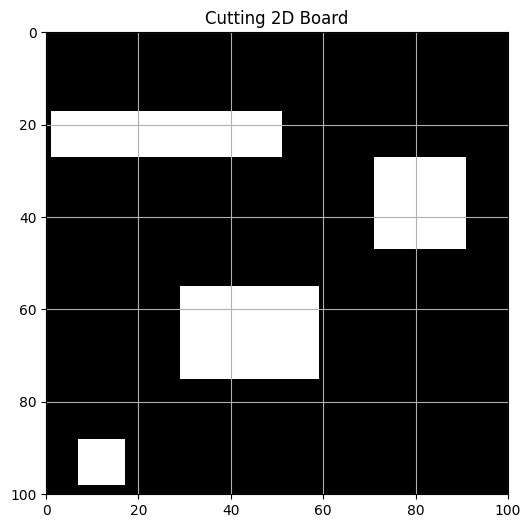

Placed piece at (10, 68), reward: -10, done: False


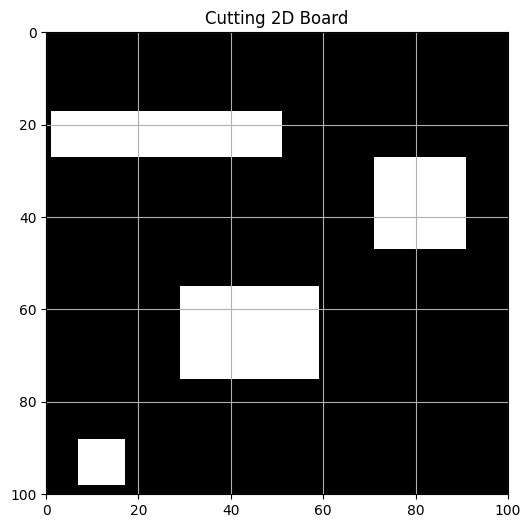

Placed piece at (14, 19), reward: -10, done: False


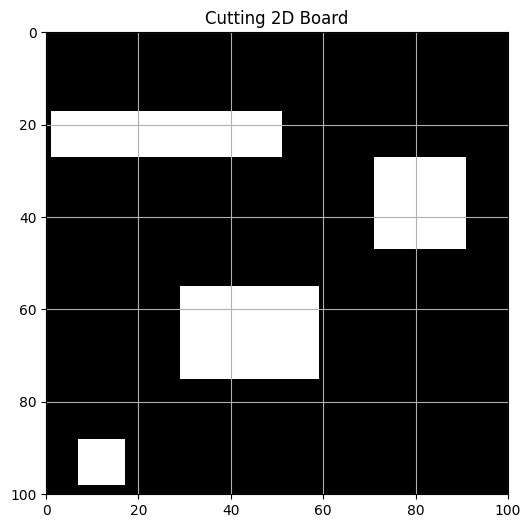

Placed piece at (49, 67), reward: -10, done: False


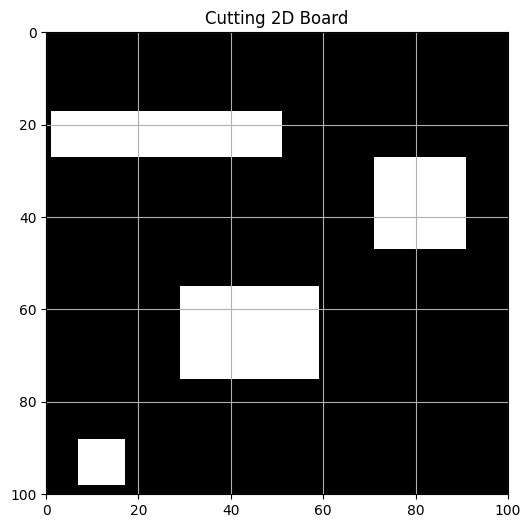

Placed piece at (59, 40), reward: -10, done: False


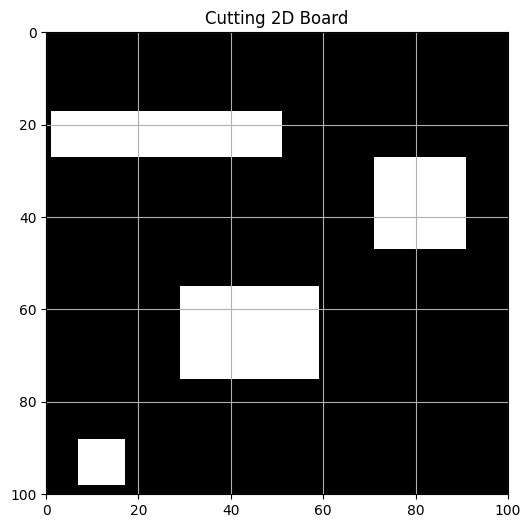

Placed piece at (47, 8), reward: -10, done: False


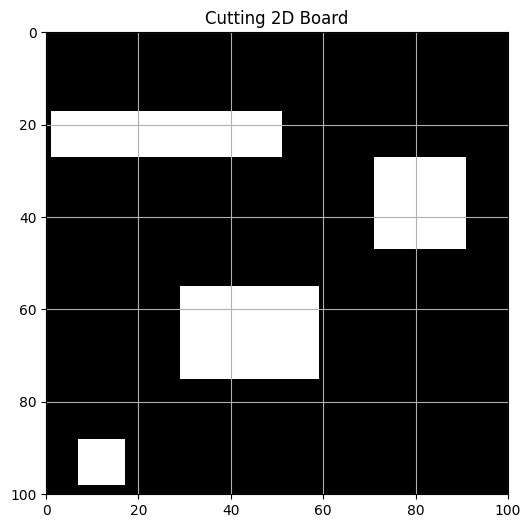

Placed piece at (34, 49), reward: -10, done: False


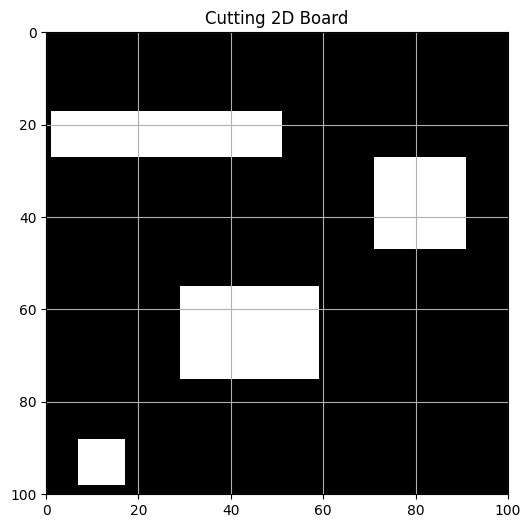

Placed piece at (53, 19), reward: -10, done: False


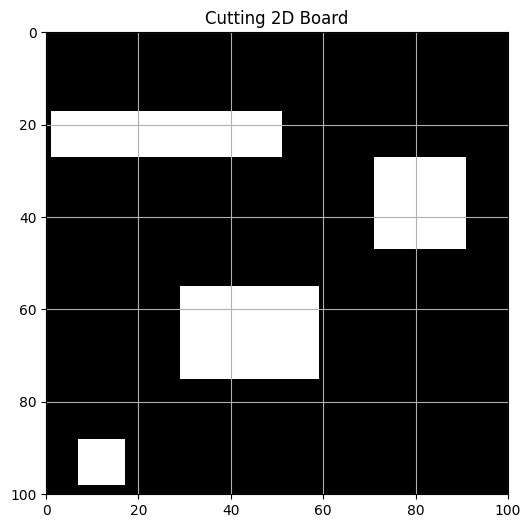

Placed piece at (22, 63), reward: -10, done: False


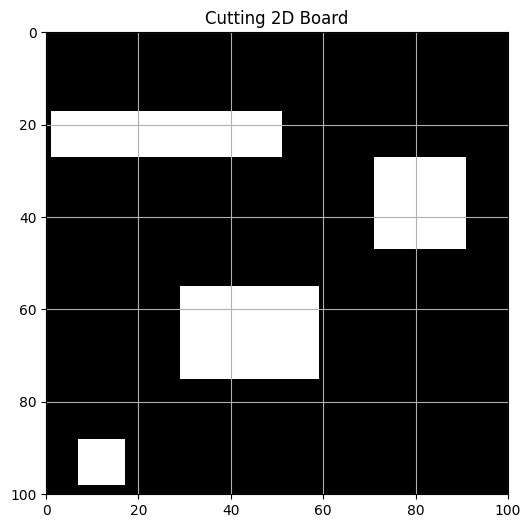

Placed piece at (1, 17), reward: -10, done: False


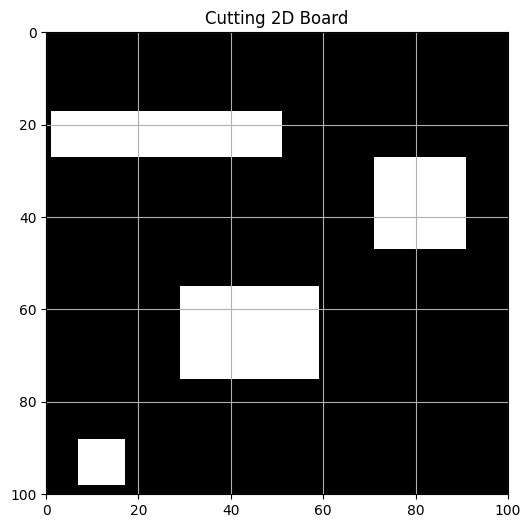

Placed piece at (12, 23), reward: -10, done: False


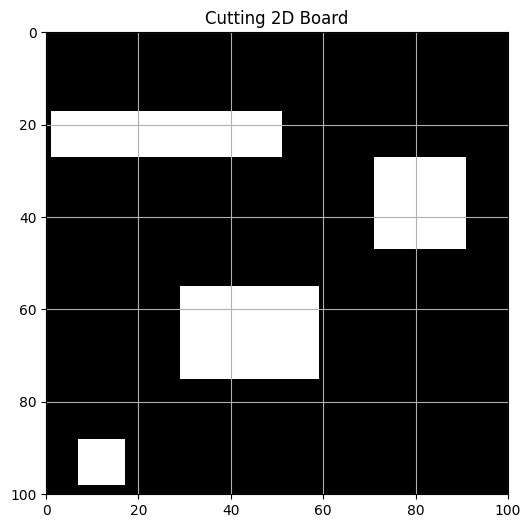

Placed piece at (2, 43), reward: -10, done: False


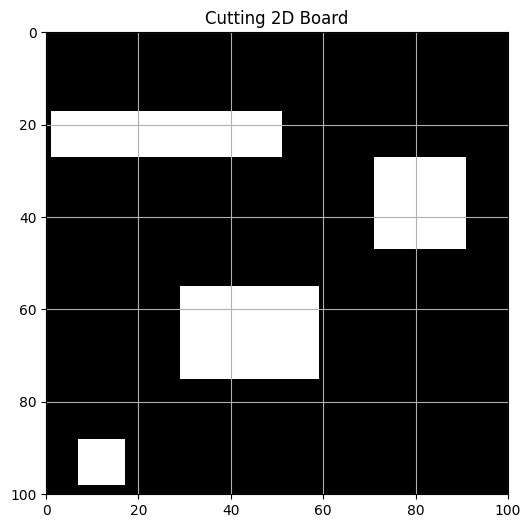

Placed piece at (0, 33), reward: -10, done: False


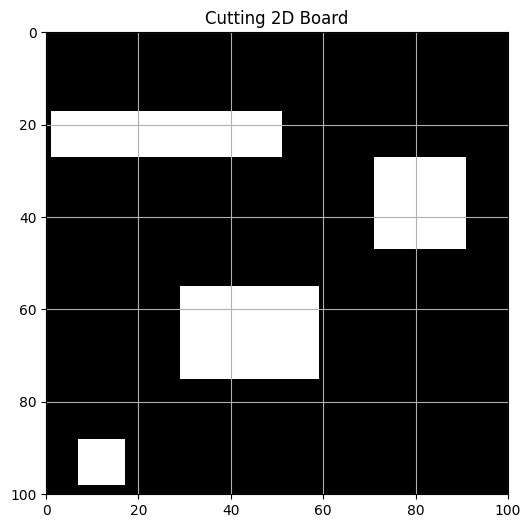

Placed piece at (57, 53), reward: -10, done: False


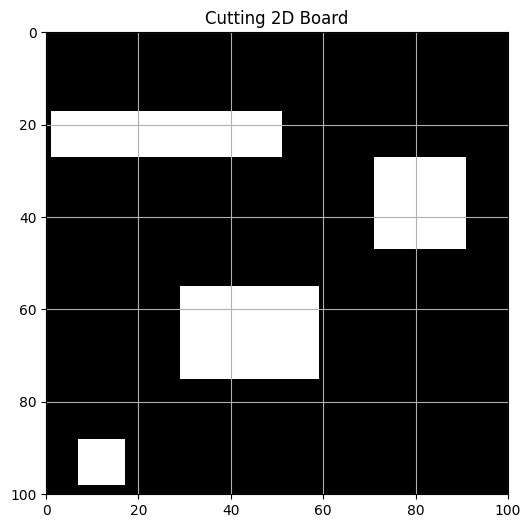

Placed piece at (35, 34), reward: -10, done: False


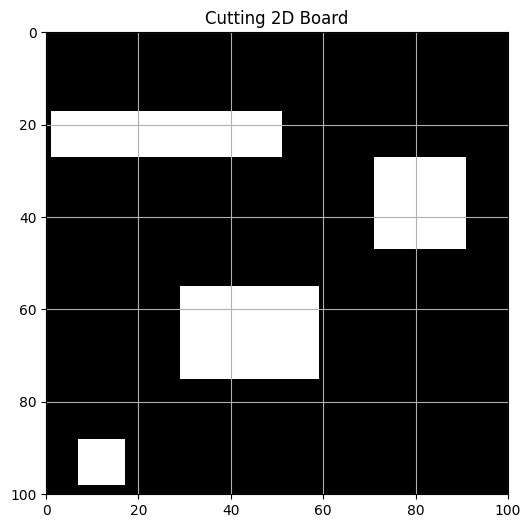

Placed piece at (34, 43), reward: -10, done: False


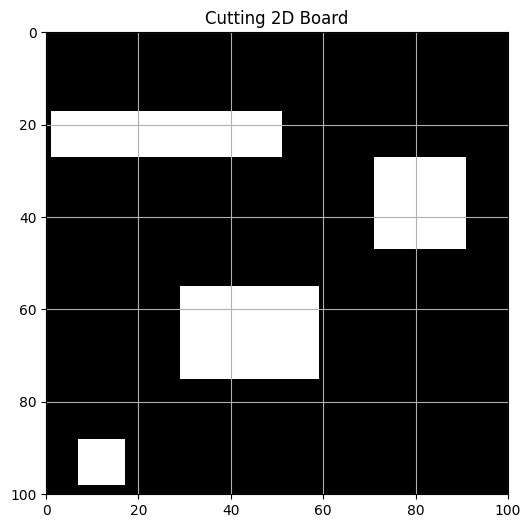

Placed piece at (16, 24), reward: -10, done: False


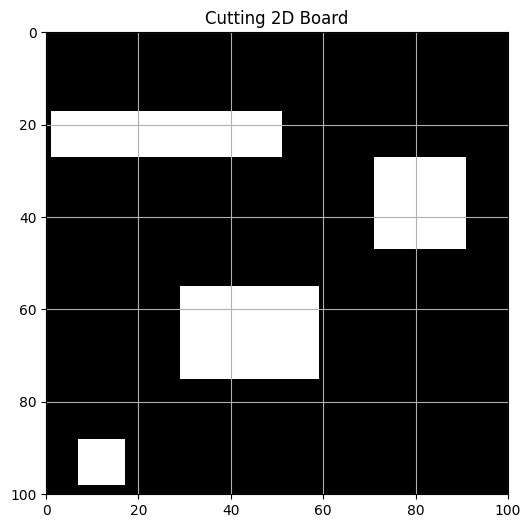

Placed piece at (52, 65), reward: -10, done: False


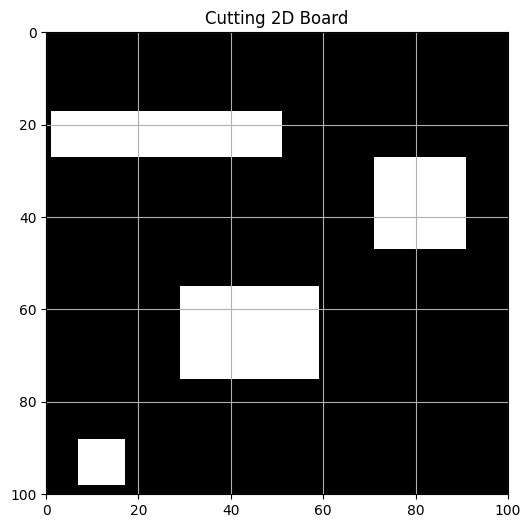

Placed piece at (59, 9), reward: 1200, done: True


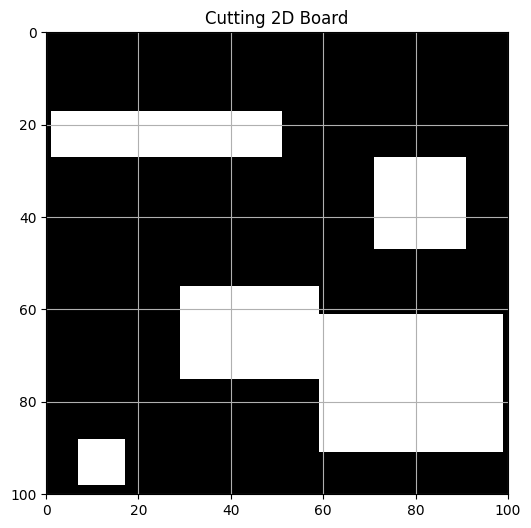

Total reward: 2400


In [ ]:
if __name__ == "__main__":
    env = Cutting2DEnv()

    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        current_piece = obs['current_piece']
        piece_width, piece_height = current_piece

        x = np.random.randint(0, env.board_width - piece_width + 1)
        y = np.random.randint(0, env.board_height - piece_height + 1)

        action = (x, y)
        obs, reward, done, info = env.step(action)
        total_reward += reward

        print(f"Placed piece at ({x}, {y}), reward: {reward}, done: {done}")

        env.render()

    print("Total reward:", total_reward)